### 📌 Project Objective:
> Analyze historical retail sales data to understand key factors affecting sales
and build a predictive model for forecasting Item_Outlet_Sales. 

##### Project Questions

In this Sales Analysis, I want to find answers to these questions: 

1. What kind of products sell more and which ones sell less?  
2. Does the type of outlet or how old it is affect sales?  
3. Do item features like fat content, weight, or type have a big role in how much they sell?  
4. Can we make a model that can predict the sales for an item in an outlet?  
5. Which features are the most important in predicting sales? 



### 1. Data Loading & Initial Exploration
> ***importing requied libraries***

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import dash
from dash import dcc, html, Input, Output, State
import joblib
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

> ***Loading Data***

In [3]:
sales = pd.read_csv('Sales Data.csv')

> ***Checking Structure***

In [4]:
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None


In [5]:
print(sales.describe())

       Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.643456         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       8.773750         0.026989    93.826500                1987.000000   
50%      12.600000         0.053931   143.012800                1999.000000   
75%      16.850000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800  


In [6]:
sales.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

> ***Checking missing values***

In [7]:
print(sales.isnull().sum())

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


### 2. Data Cleaning & Preprocessing

> ***Fixing Item_Fat_Content***

In [8]:
print(sales["Item_Fat_Content"].unique())

# ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']

['Low Fat' 'Regular' 'low fat' 'LF' 'reg']


In [9]:
sales['Item_Fat_Content'] = sales['Item_Fat_Content'].replace({
'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})

print(sales['Item_Fat_Content'].nunique())

2


> ***Creating Outlet_Age Column***

In [10]:
sales['Outlet_Age'] = 2025 - sales['Outlet_Establishment_Year']

print(sales['Outlet_Age'].info())

<class 'pandas.core.series.Series'>
RangeIndex: 8523 entries, 0 to 8522
Series name: Outlet_Age
Non-Null Count  Dtype
--------------  -----
8523 non-null   int64
dtypes: int64(1)
memory usage: 66.7 KB
None


> ***Handling missing values***

In [11]:
item_weight_median = sales['Item_Weight'].median()
sales['Item_Weight'].fillna(item_weight_median, inplace=True)
sales['Outlet_Size'].fillna('Unknown', inplace=True)

print(sales[['Outlet_Size', 'Item_Weight']].isnull().sum())

Outlet_Size    0
Item_Weight    0
dtype: int64


> ***Saving cleaned data for further process***

In [19]:
sales.to_csv('cleaned_sales_data.csv', index=False)

### 3. Exploratory Data Analysis(EDA)

> ***Loading cleaned data sales files***

In [20]:
sales = pd.read_csv("cleaned_sales_data.csv")

> ***Sales Performance Analysis***

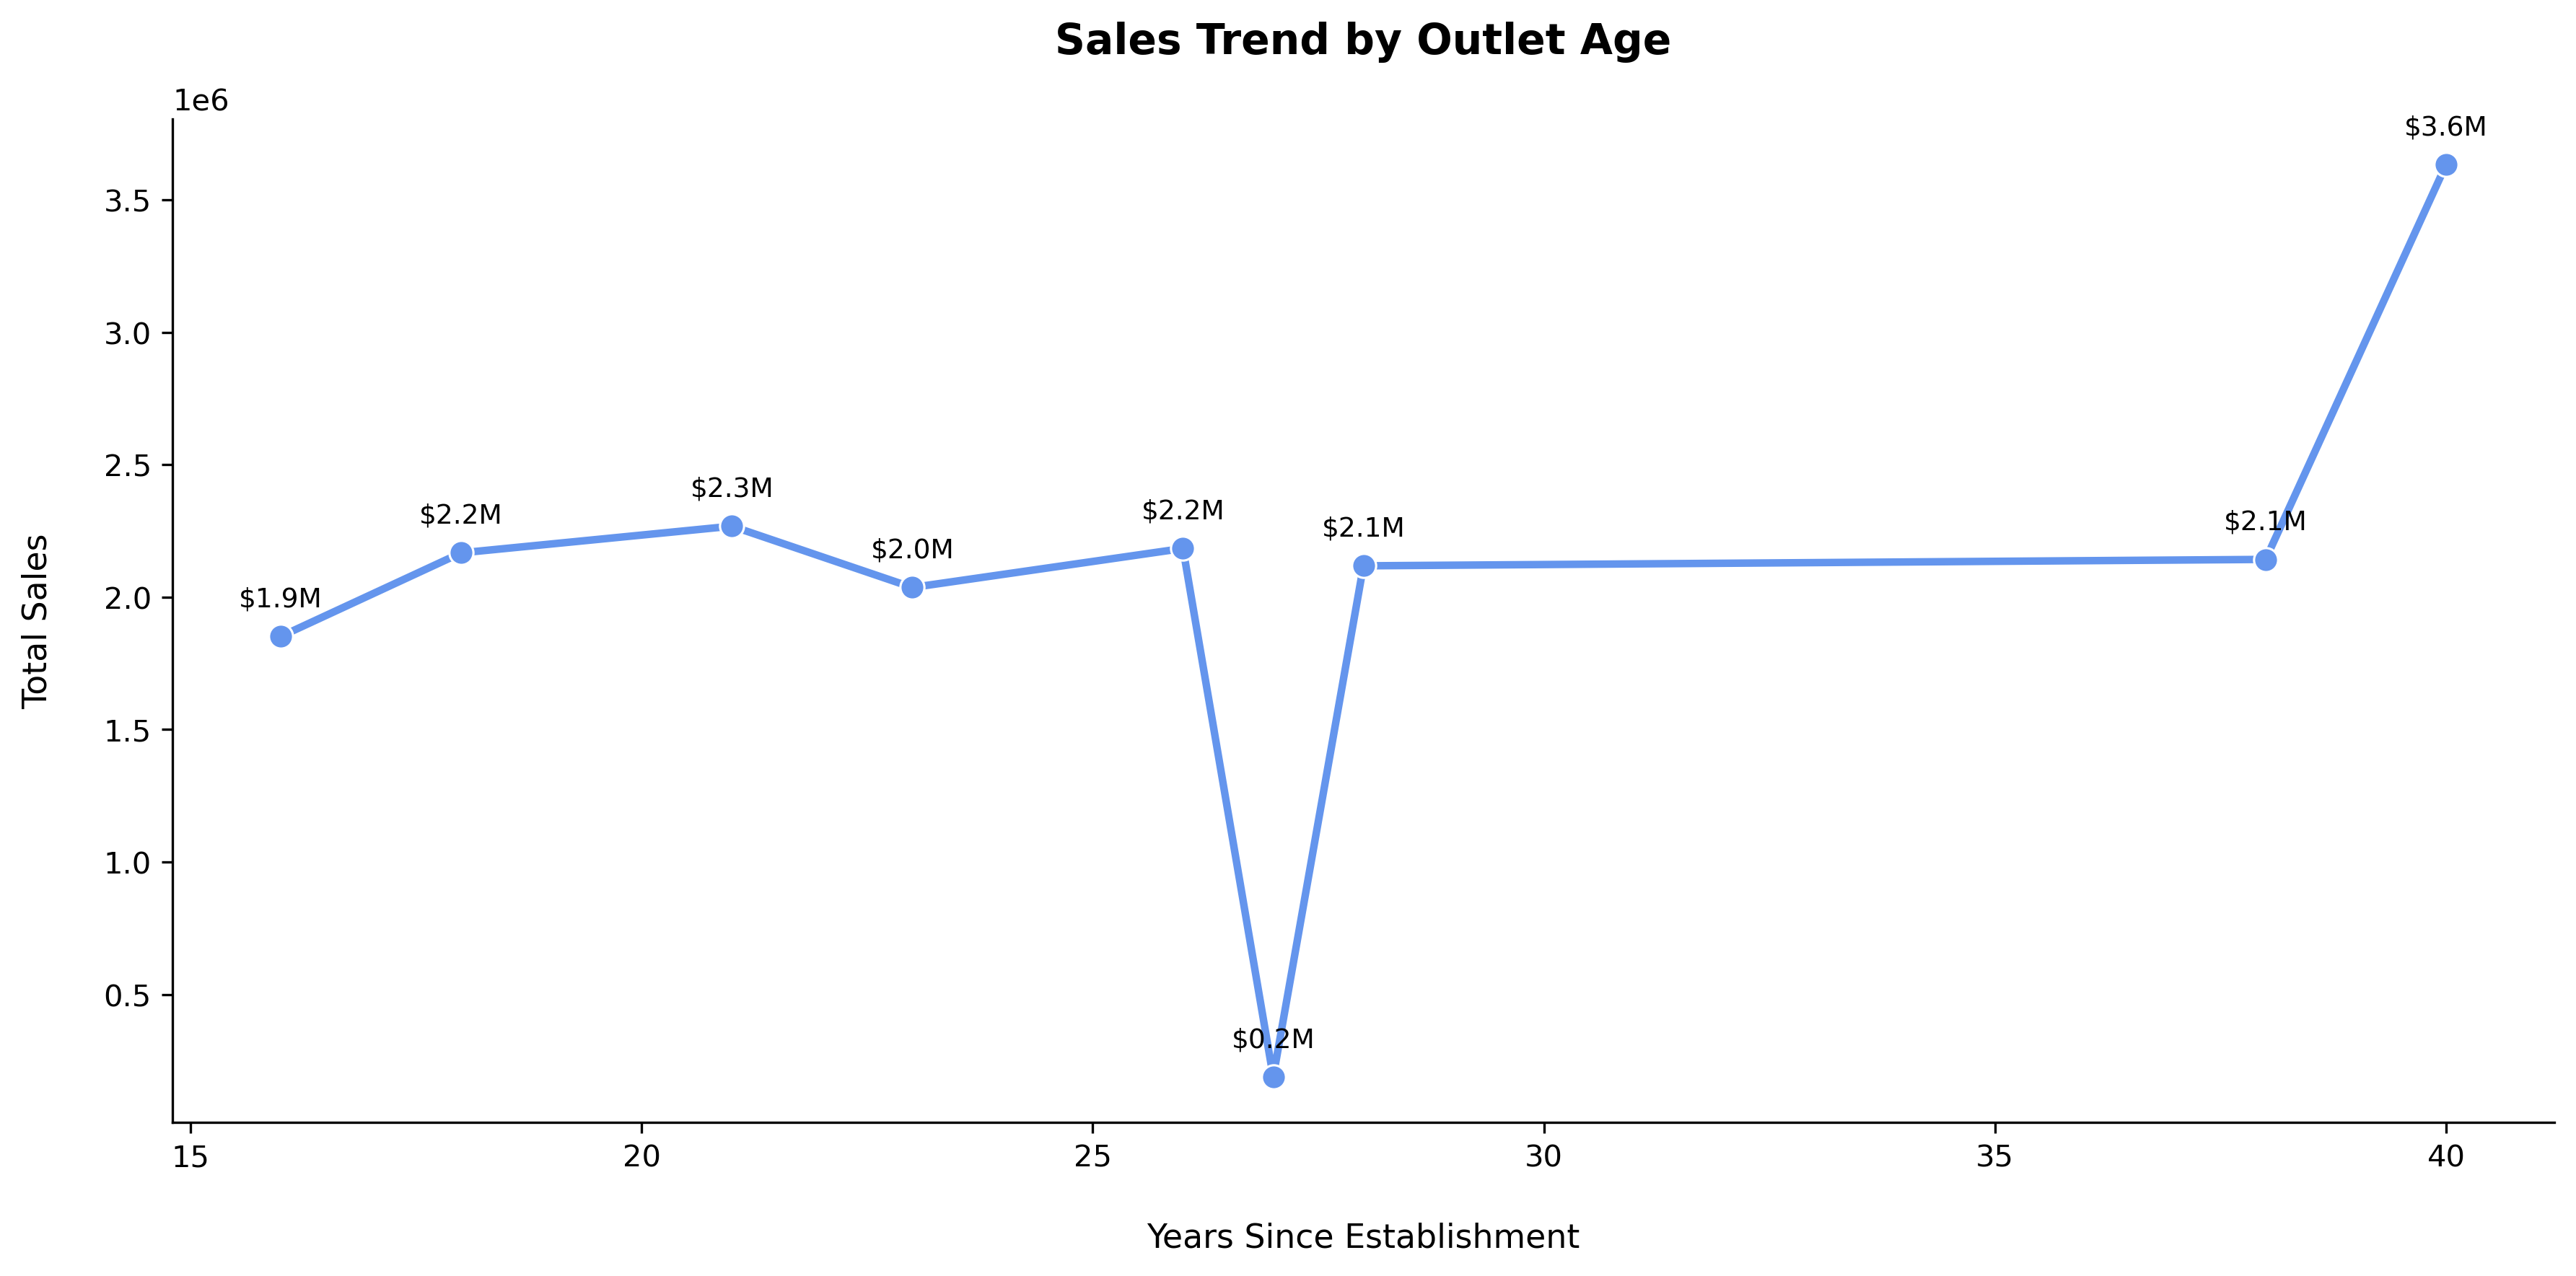

In [14]:
plt.figure(figsize=(12, 6), dpi=300)
sns.set_palette("husl")

ax = sns.lineplot(
    data=sales.groupby('Outlet_Age')['Item_Outlet_Sales'].sum().reset_index(),
    x='Outlet_Age',
    y='Item_Outlet_Sales',
    marker='o',
    markersize=8,
    linewidth=2.5,
    color='cornflowerblue'
)

plt.title('Sales Trend by Outlet Age\n', fontsize=14, fontweight='bold')
plt.xlabel('\nYears Since Establishment', fontsize=11)
plt.ylabel('Total Sales\n', fontsize=11)
sns.despine()

for x, y in zip(ax.lines[0].get_xdata(), ax.lines[0].get_ydata()):
    ax.annotate(f'${y/1e6:.1f}M', 
                (x, y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center',
                fontsize=9)

plt.tight_layout()
plt.show()

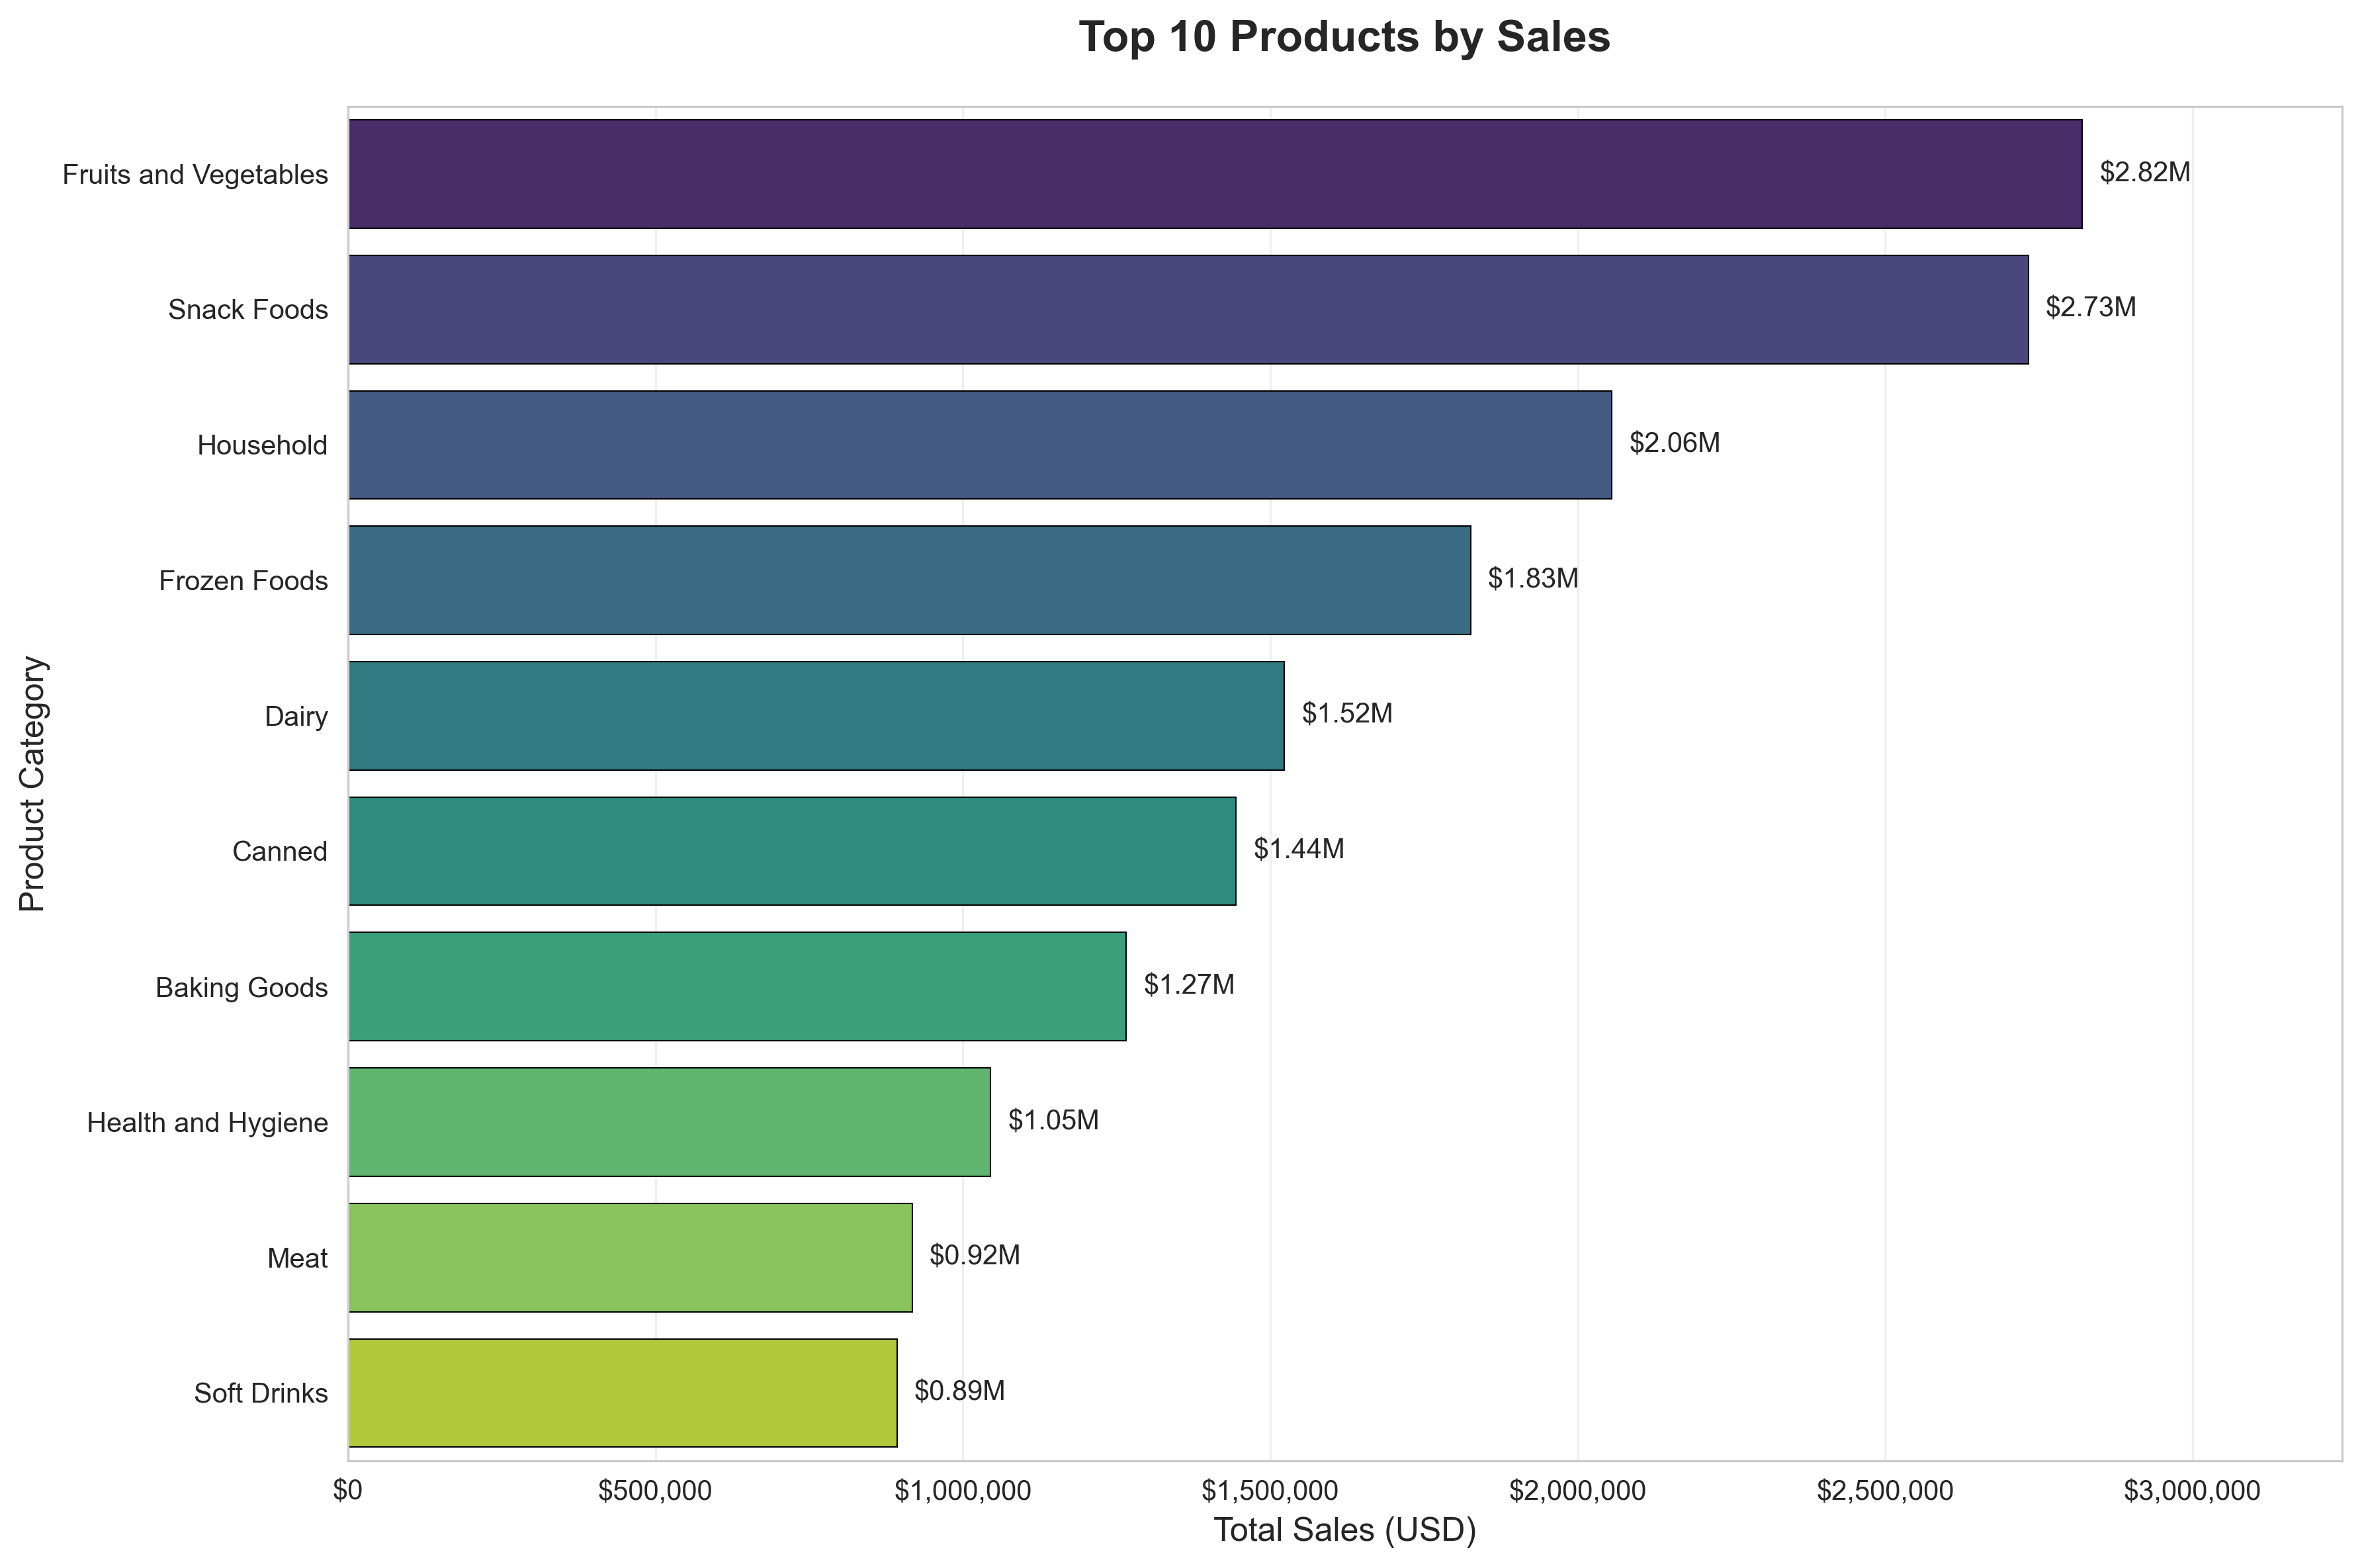

In [22]:
top_products = sales.groupby('Item_Type')['Item_Outlet_Sales'].sum().nlargest(10)

plt.figure(figsize=(12, 8), dpi=300)
sns.set_style("whitegrid")

ax = sns.barplot(
    x=top_products.values,
    y=top_products.index,
    color='royalblue',
    palette="viridis",
    edgecolor='black',
    linewidth=0.5
)

for i, (value, name) in enumerate(zip(top_products.values, top_products.index)):
    ax.text(value + max(top_products.values)*0.01,
            i,
            f'${value/1e6:.2f}M',
            ha='left',
            va='center',
            fontsize=10)

plt.title('Top 10 Products by Sales', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Total Sales (USD)', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.xlim(0, max(top_products.values) * 1.15)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,.0f}".format(x)))
plt.grid(axis='x', alpha=0.3)
plt.grid(axis='y', visible=False)

plt.tight_layout()
plt.show()

In [28]:
bottom_products = sales.groupby('Item_Type')['Item_Outlet_Sales'].sum().nsmallest(10)

plt.figure(figsize=(12, 8), dpi=120)
sns.set_style("whitegrid")
sns.set_palette("Reds_r", n_colors=len(bottom_products))

ax = sns.barplot(
    x=bottom_products.values,
    y=bottom_products.index,
    palette='Reds_r',
    edgecolor='black',
    linewidth=0.5
)

for i, (value, name) in enumerate(zip(bottom_products.values, bottom_products.index)):
    ax.text(value + max(bottom_products.values)*0.01, 
            i, 
            f'${value/1e6:.2f}M', 
            ha='left', 
            va='center',
            fontsize=10)

plt.title('Bottom 10 Products by Sales', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Total Sales (USD)', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.xlim(0, max(bottom_products.values) * 1.15)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,.0f}".format(x)))
plt.grid(axis='x', alpha=0.3)
plt.grid(axis='y', visible=False)

plt.tight_layout()
plt.show()

In [30]:
plt.figure(figsize=(12, 8), dpi=300)
sns.set_style("whitegrid")

ax = sns.boxplot(
    data=sales,
    x='Outlet_Type',
    y='Item_Outlet_Sales',
    palette='viridis',
    linewidth=1,
    fliersize=3
)

plt.title('Sales Distribution by Outlet Type', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('')
plt.ylabel('Sales Amount', fontsize=12)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,.0f}".format(x)))
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

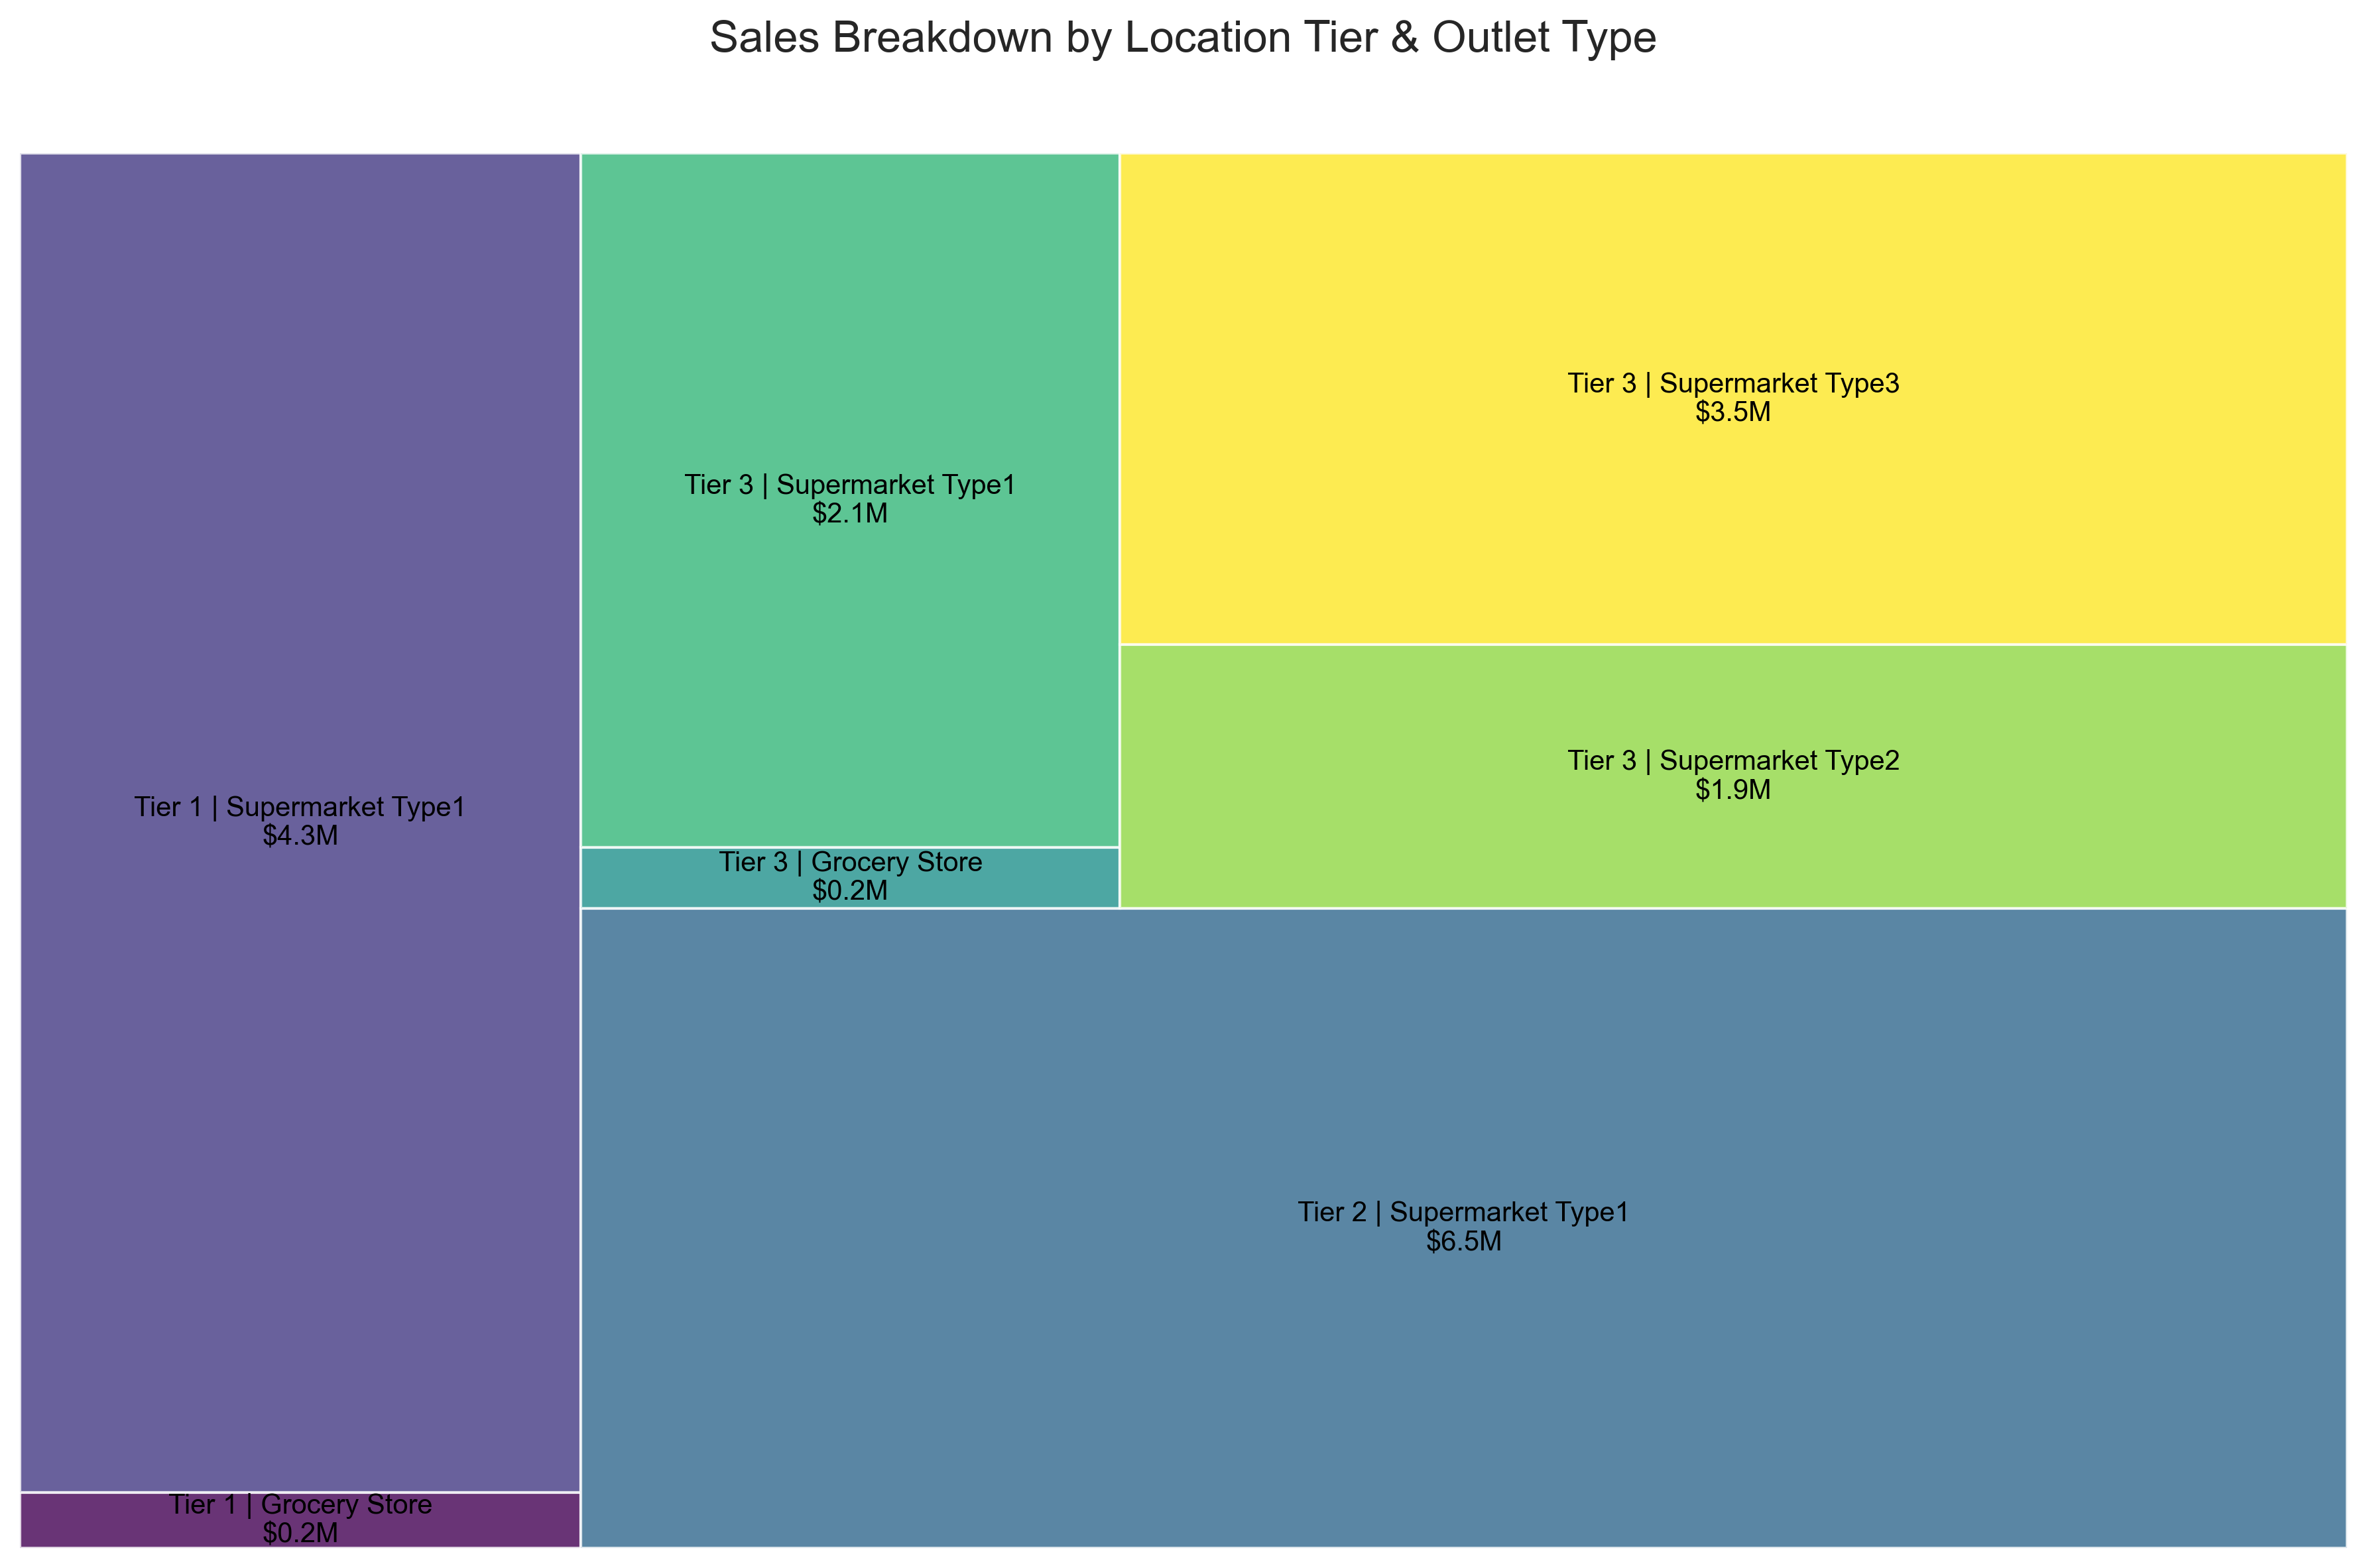

In [44]:
plt.figure(figsize=(12, 8), dpi=300)

grouped = sales.groupby(['Outlet_Location_Type', 'Outlet_Type'])['Item_Outlet_Sales'].sum().reset_index()
grouped['label'] = grouped['Outlet_Location_Type'] + ' | ' + grouped['Outlet_Type']
grouped['value_str'] = grouped['Item_Outlet_Sales'].apply(lambda x: f"${x/1e6:.1f}M")

squarify.plot(
    sizes=grouped['Item_Outlet_Sales'],
    label=[f"{label}\n{val}" for label, val in zip(grouped['label'], grouped['value_str'])],
    color=plt.cm.viridis(np.linspace(0, 1, len(grouped))),
    alpha=0.8,
    text_kwargs={'fontsize':10, 'color':'black'}
)

plt.title('Sales Breakdown by Location Tier & Outlet Type\n', fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

In [46]:
plt.figure(figsize=(12, 8), dpi=300)

scatter = sns.scatterplot(
    data=sales,
    x='Item_MRP',
    y='Item_Outlet_Sales',
    hue='Item_Type',
    alpha=0.7,
    palette='viridis',
    s=80
)

sns.regplot(
    data=sales,
    x='Item_MRP',
    y='Item_Outlet_Sales',
    scatter=False,
    lowess=True,
    line_kws={'color':'red', 'linestyle':'--'}
)

plt.title('Price vs Sales Relationship', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Product Price (MRP)')
plt.ylabel('Sales Amount')
plt.legend(title='Item Type', bbox_to_anchor=(1.05, 1), loc='upper left')

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,.0f}".format(x)))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,.0f}".format(x)))

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

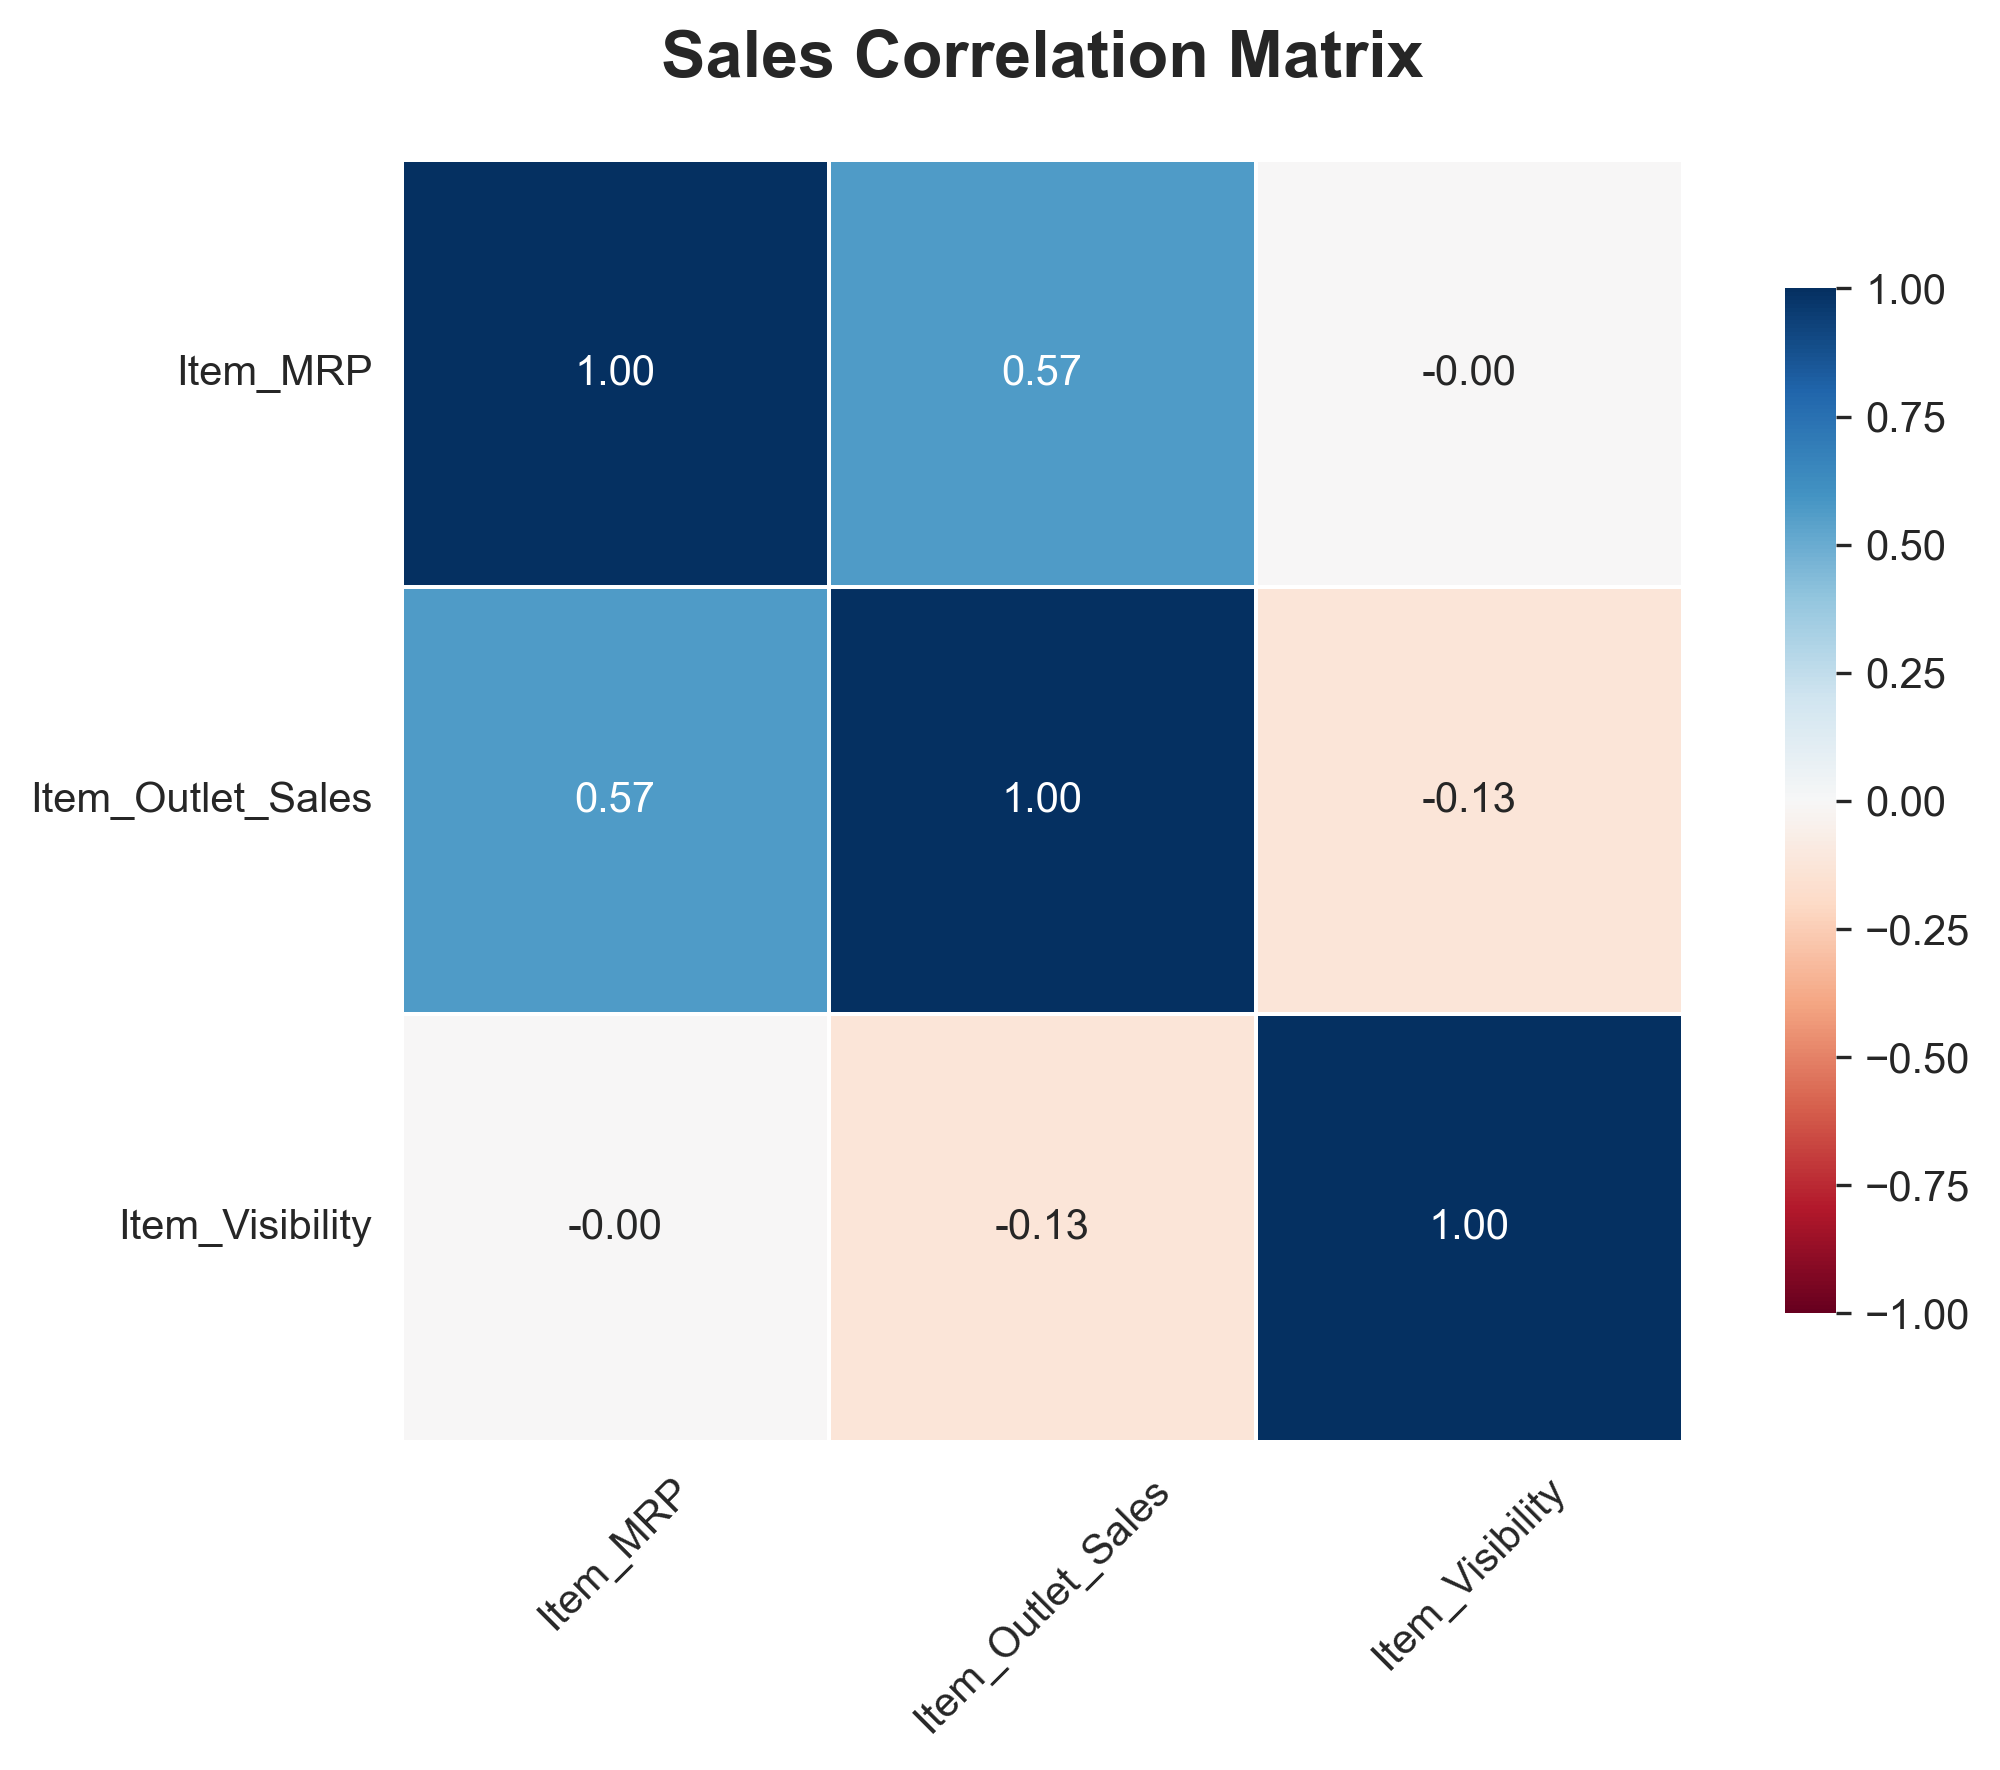

In [48]:
plt.figure(figsize=(8, 6), dpi=300)

corr_matrix = sales[['Item_MRP', 'Item_Outlet_Sales', 'Item_Visibility']].corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title('Sales Correlation Matrix', fontsize=16, pad=20, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

> ***Product Analysis***

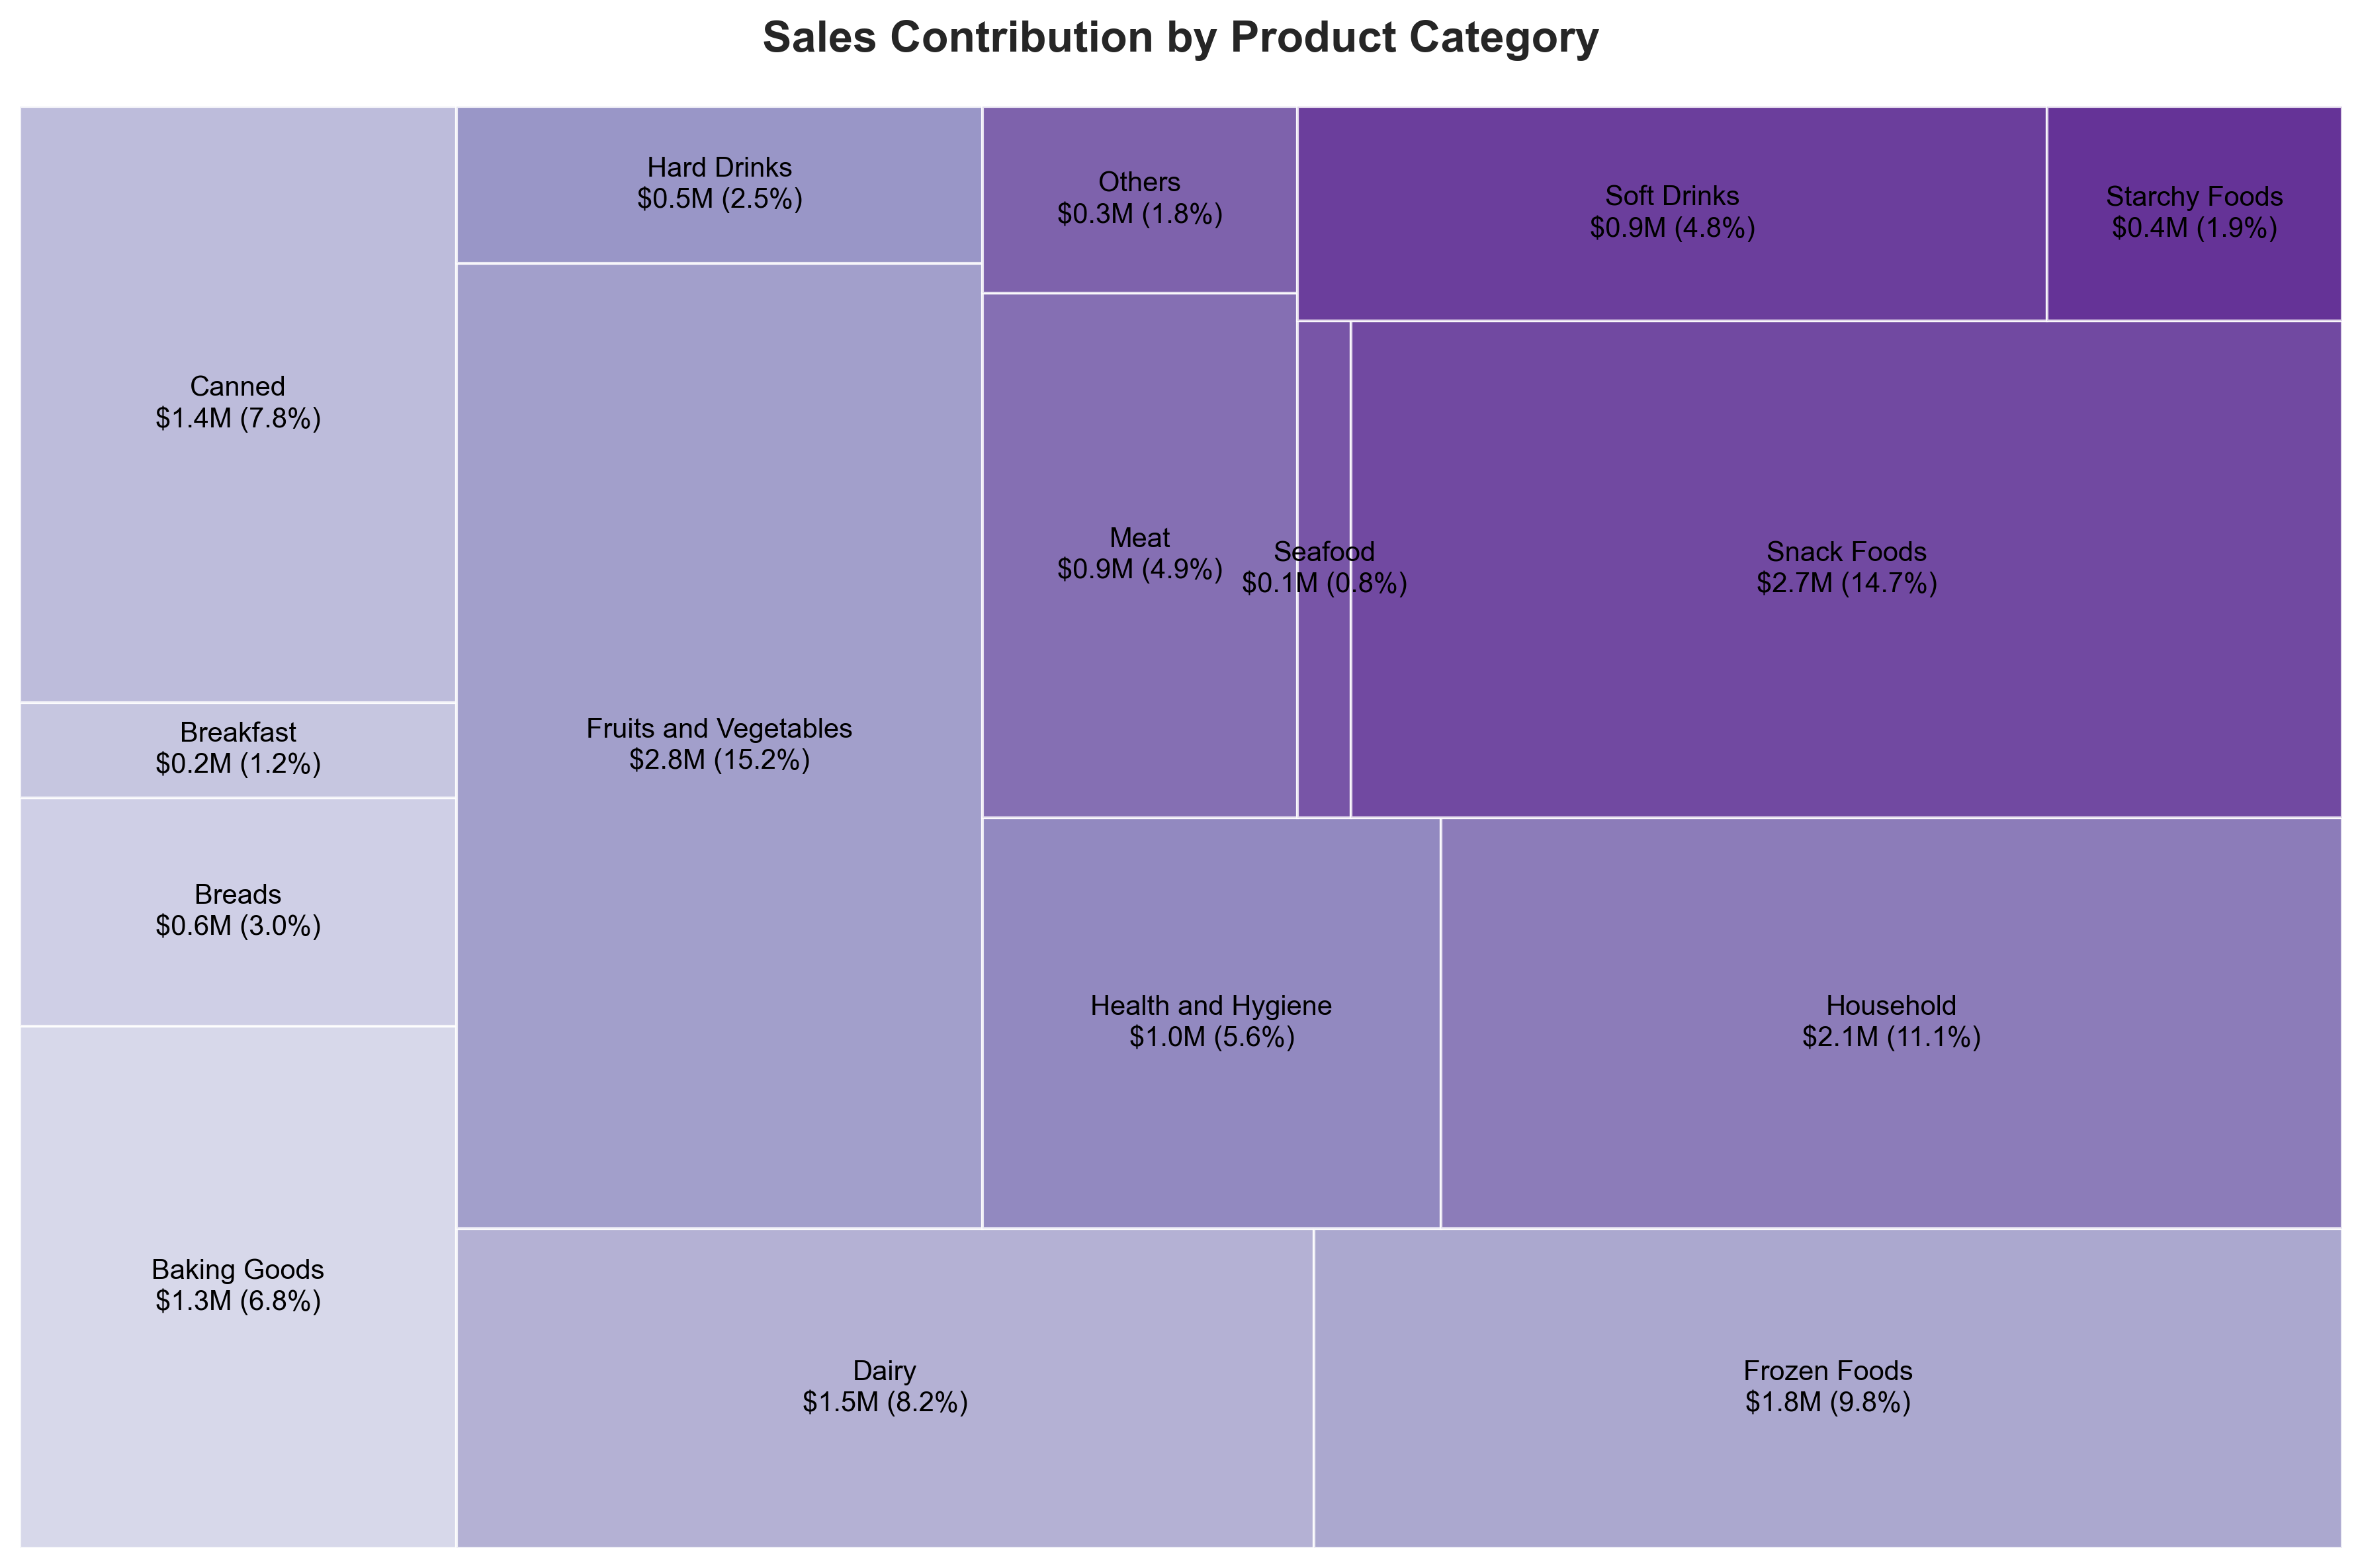

In [75]:
plt.figure(figsize=(12, 8), dpi=300)

grouped = sales.groupby('Item_Type')['Item_Outlet_Sales'].sum().reset_index()
grouped['percent'] = grouped['Item_Outlet_Sales'] / grouped['Item_Outlet_Sales'].sum() * 100
grouped['label'] = grouped.apply(lambda x: f"{x['Item_Type']}\n${x['Item_Outlet_Sales']/1e6:.1f}M ({x['percent']:.1f}%)", axis=1)

squarify.plot(
    sizes=grouped['Item_Outlet_Sales'],
    label=grouped['label'],
    color=plt.cm.Purples(np.linspace(0.3, 1, len(grouped))),
    alpha=0.8,
    text_kwargs={'fontsize':10, 'color':'black'}
)

plt.title('Sales Contribution by Product Category', fontsize=16, pad=20, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

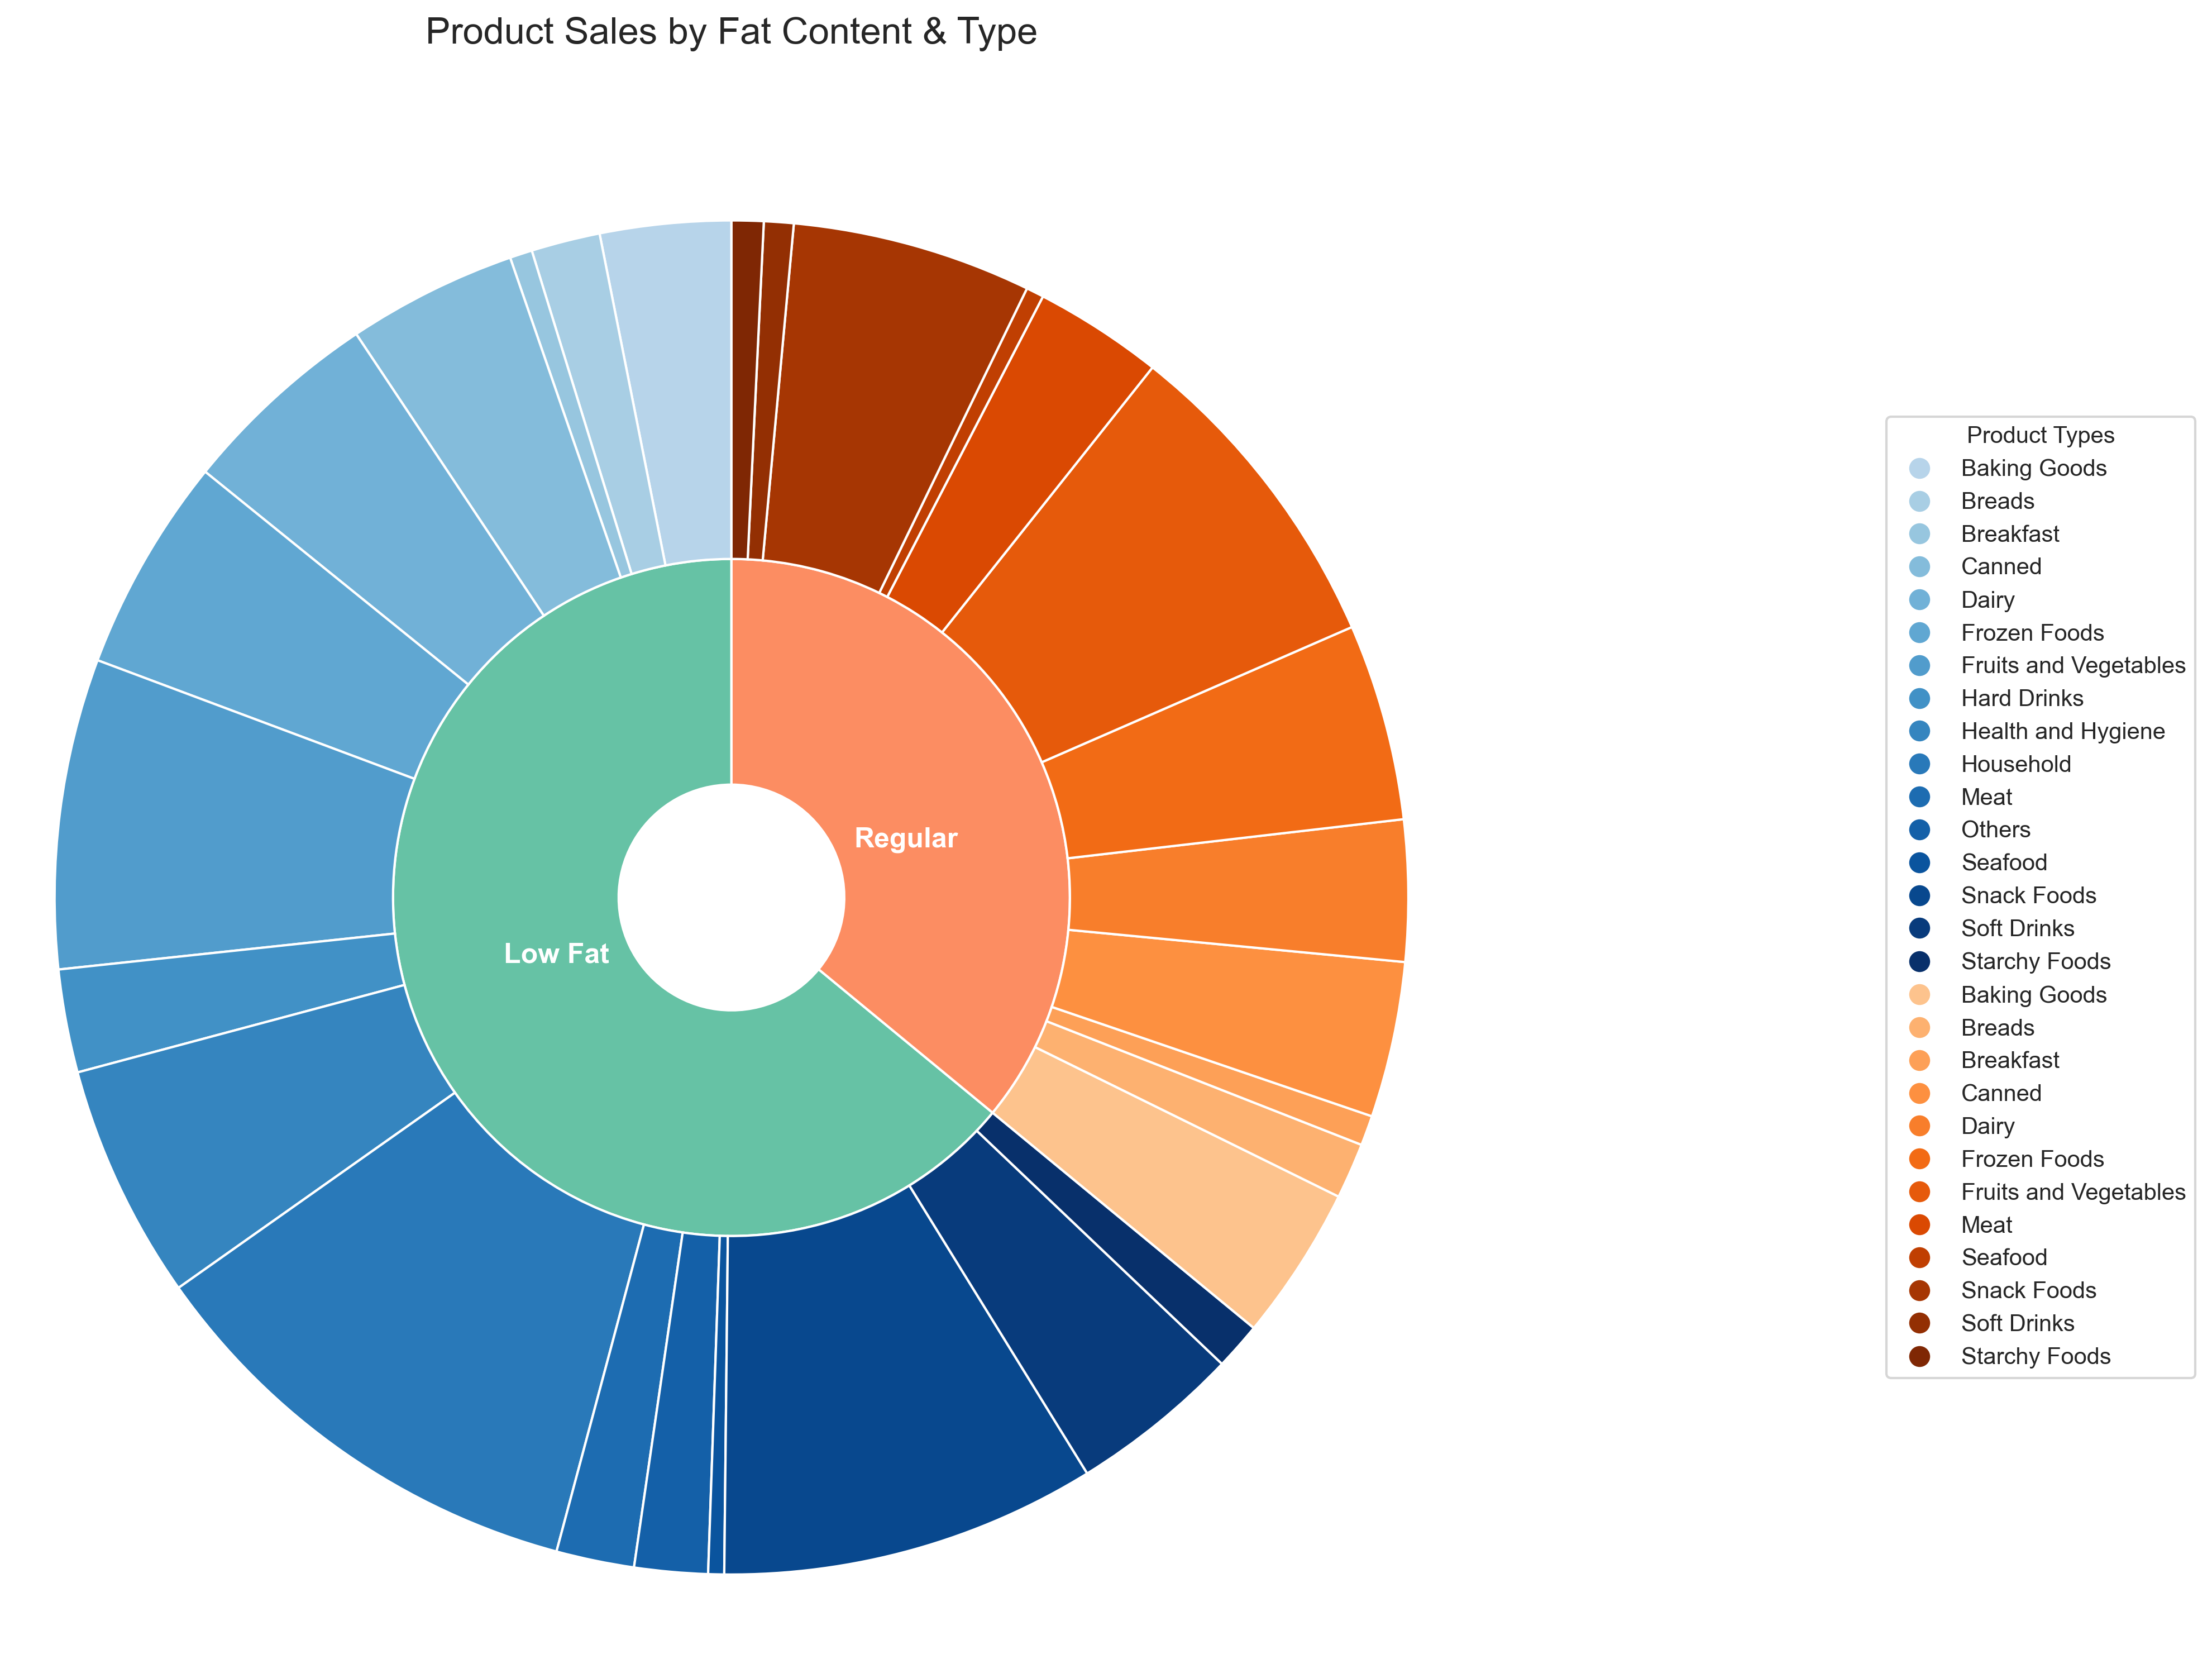

In [70]:
plt.figure(figsize=(14, 10), dpi=)

fat_colors = {'Low Fat': '#66c2a5', 'Regular': '#fc8d62'}

fat_sales = sales.groupby('Item_Fat_Content')['Item_Outlet_Sales'].sum()

wedges_inner, inner_labels = plt.pie(
    fat_sales,
    labels=fat_sales.index,
    radius=0.3,
    colors=[fat_colors[x] for x in fat_sales.index],
    wedgeprops=dict(width=0.2, edgecolor='w'),
    startangle=90,
    labeldistance=0.4
)

for text in inner_labels:
    text.set_color('white')
    text.set_fontweight('bold')
    text.set_fontsize(12)

product_sales = sales.groupby(['Item_Fat_Content', 'Item_Type'])['Item_Outlet_Sales'].sum()

product_colors = {}

for fat_type in fat_sales.index:
    products = product_sales[fat_type].index
    n_products = len(products)
    cmap = plt.cm.Blues if fat_type == 'Low Fat' else plt.cm.Oranges
    for i, product in enumerate(products):
        product_colors[(fat_type, product)] = cmap(0.3 + 0.7 * i / max(n_products - 1, 1))

outer_colors = [product_colors[key] for key in product_sales.index]

wedges_outer, _ = plt.pie(
    product_sales,
    radius=0.6,
    colors=outer_colors,
    wedgeprops=dict(width=0.3, edgecolor='w'),
    startangle=90
)

product_legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label=ptype,
               markerfacecolor=product_colors[(fat, ptype)], markersize=10)
    for (fat, ptype) in product_sales.index
]

plt.legend(
    handles=product_legend_elements,
    loc='center left',
    bbox_to_anchor=(1.3, 0.5),
    title="Product Types"
)

plt.title('Product Sales by Fat Content & Type\n', fontsize=16, pad=30)
plt.axis('equal')
plt.tight_layout()
plt.show()


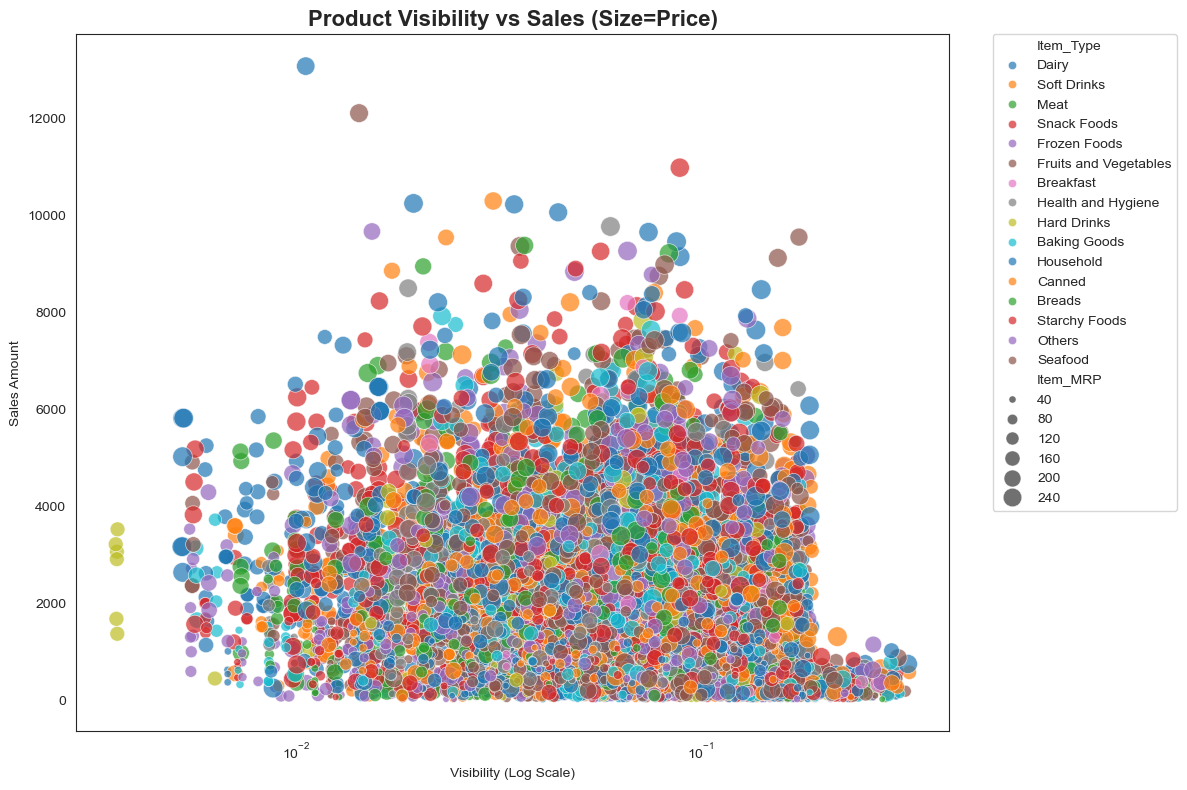

In [57]:


# Filter out zero or negative visibility values for log scale
sales_filtered = sales[sales['Item_Visibility'] > 0].copy()

plt.figure(figsize=(12, 8))

# Create a log scale for x axis
plt.xscale('log')

# Create scatter plot with seaborn, specifying size and hue (color)
scatter = sns.scatterplot(
    data=sales_filtered,
    x='Item_Visibility',
    y='Item_Outlet_Sales',
    hue='Item_Type',
    size='Item_MRP',
    palette='tab10',
    sizes=(20, 200),  # Adjust marker size scale if needed
    alpha=0.7,
    edgecolor='w',
    linewidth=0.5
)

plt.title('Product Visibility vs Sales (Size=Price)', fontsize=16, fontweight='bold')
plt.xlabel('Visibility (Log Scale)')
plt.ylabel('Sales Amount')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()


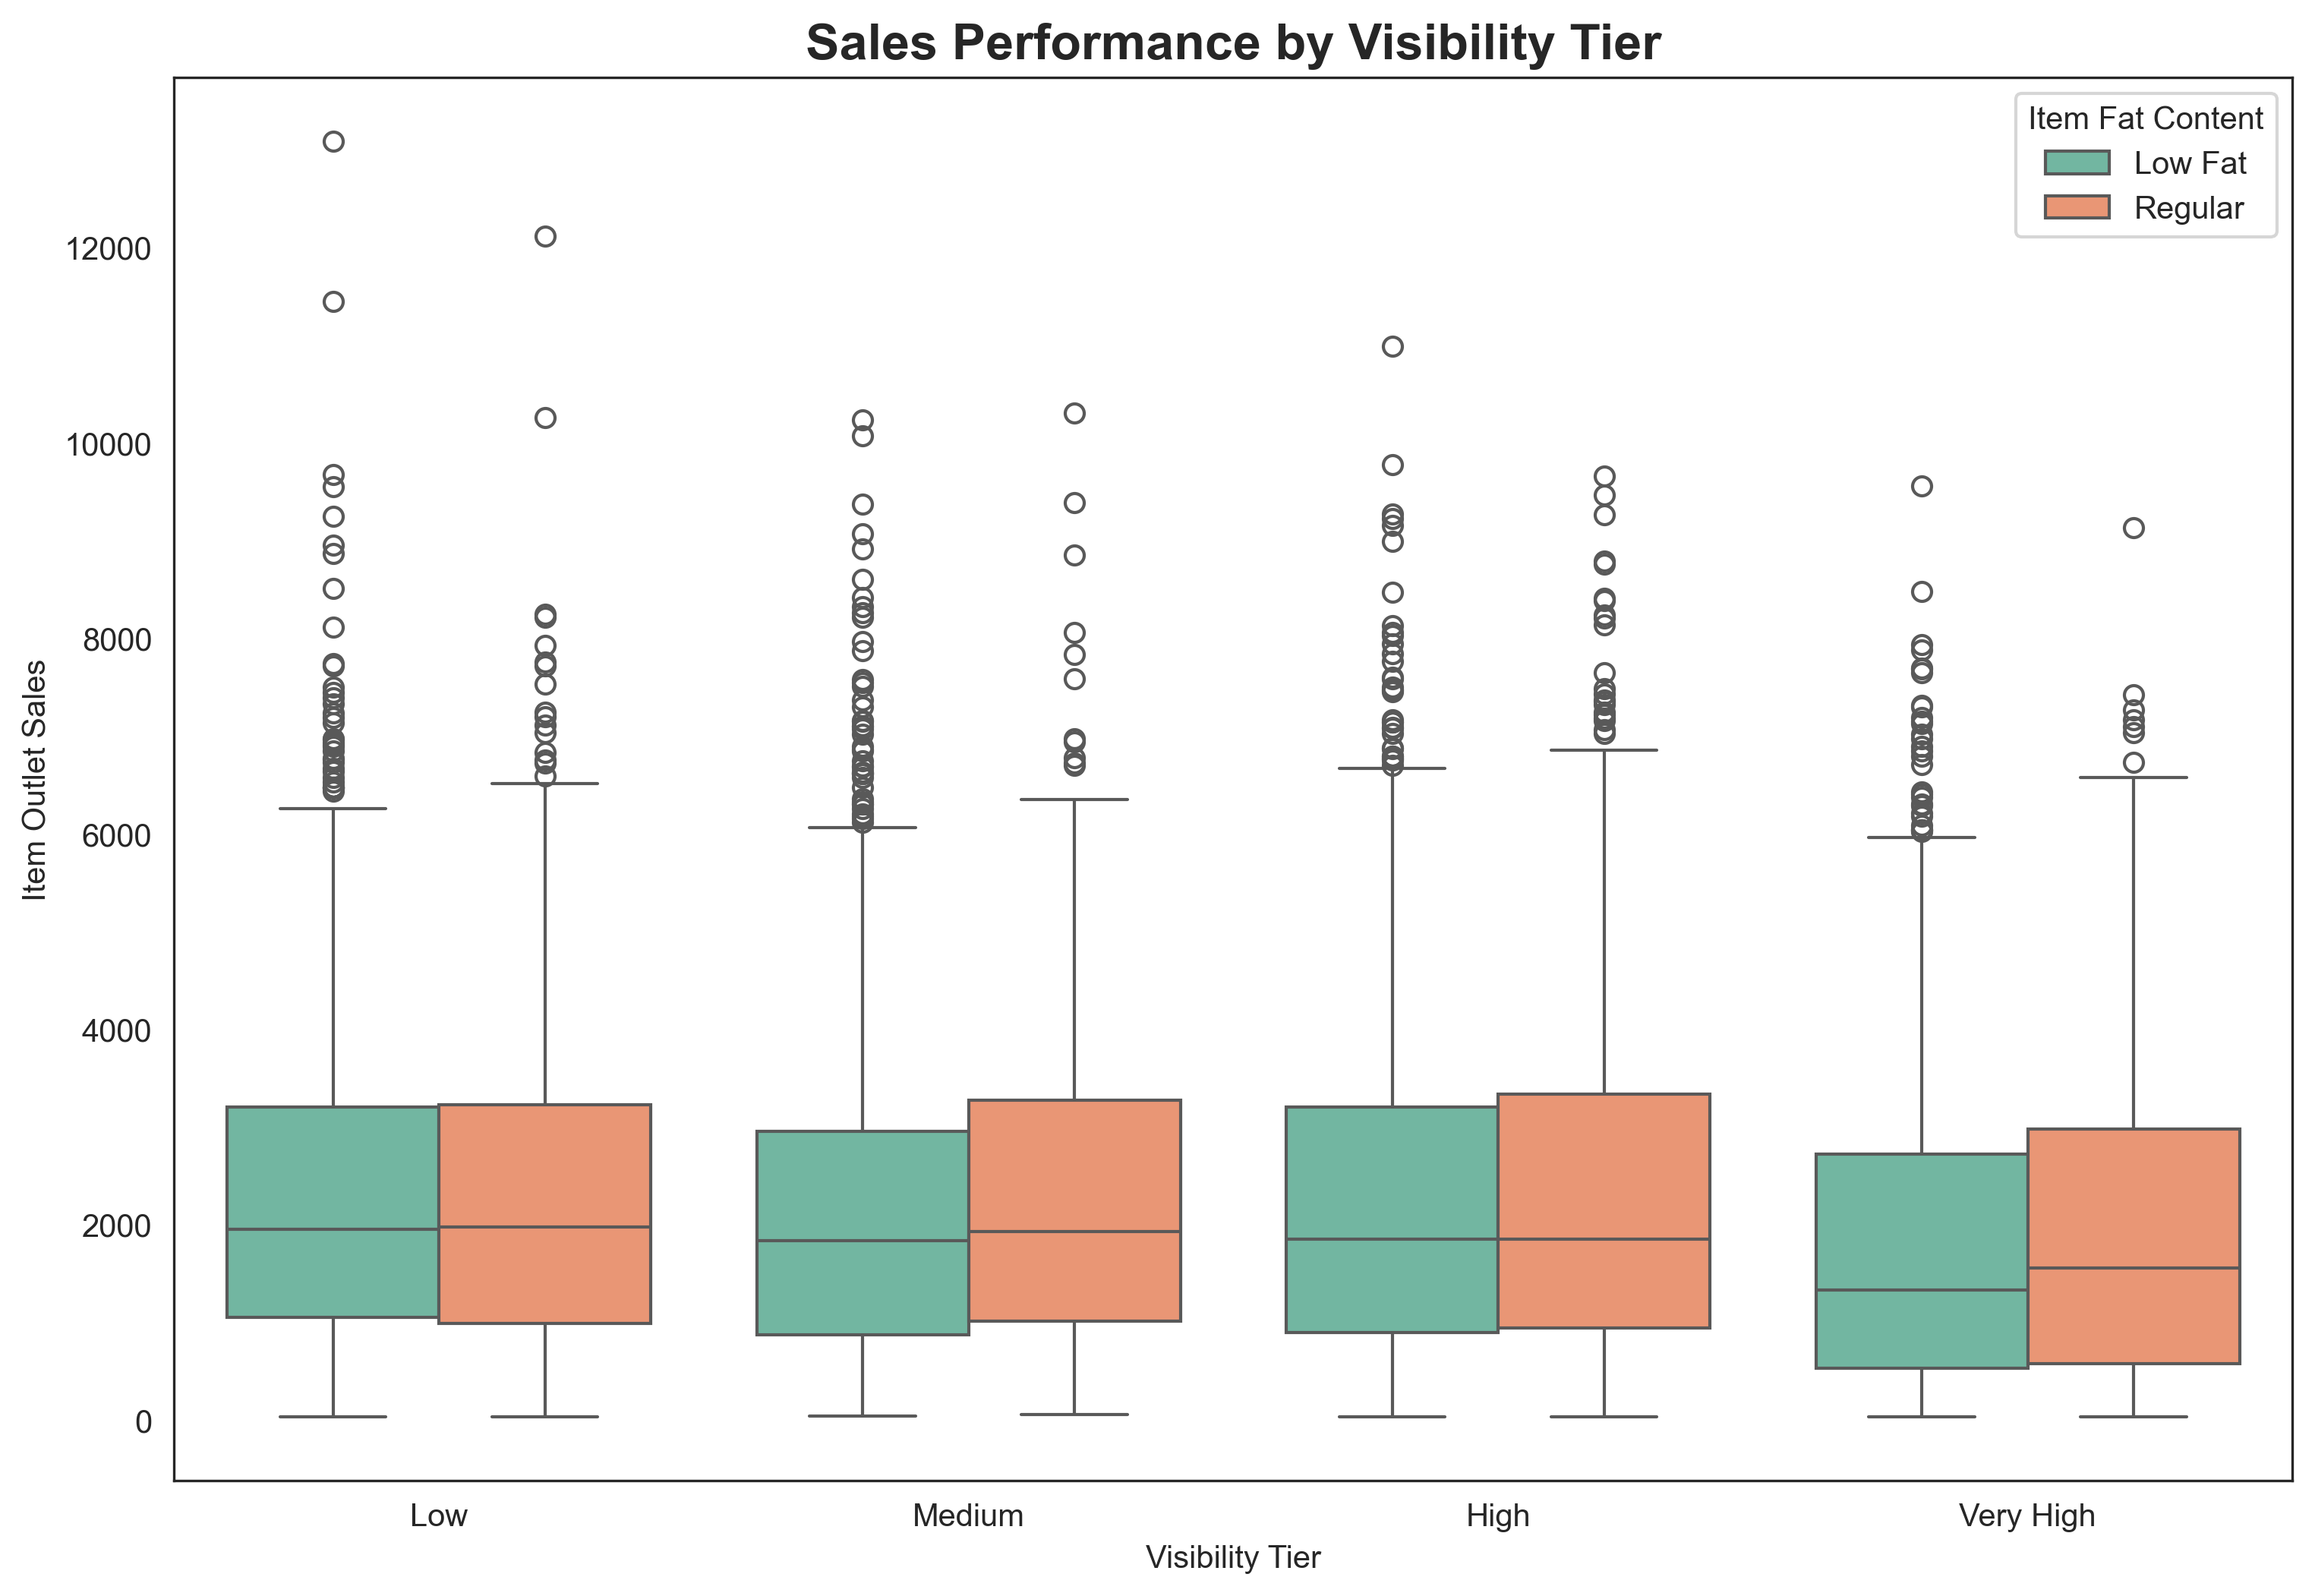

In [77]:
sales['Visibility_Tier'] = pd.qcut(sales['Item_Visibility'], q=4, 
                                  labels=['Low', 'Medium', 'High', 'Very High'])

plt.figure(figsize=(12, 8), dpi=300)
sns.boxplot(
    data=sales,
    x='Visibility_Tier',
    y='Item_Outlet_Sales',
    hue='Item_Fat_Content',
    palette={'Low Fat': '#66c2a5', 'Regular': '#fc8d62'}
)

plt.title('Sales Performance by Visibility Tier', fontsize=16, fontweight='bold')
plt.xlabel('Visibility Tier')
plt.ylabel('Item Outlet Sales')
plt.legend(title='Item Fat Content')
plt.show()

In [80]:
plt.figure(figsize=(12, 8), dpi=300)
sns.histplot(
    data=sales,
    x='Item_MRP',
    y='Item_Outlet_Sales',
    bins=20,
    pmax=0.9,   
    cbar=False,
    cmap='mako'
)

plt.title('Sales Density by Price Point', fontsize=16, fontweight='bold')
plt.xlabel('Item MRP')
plt.ylabel('Item Outlet Sales')
plt.show()

> ***Outlet Performance Analysis***

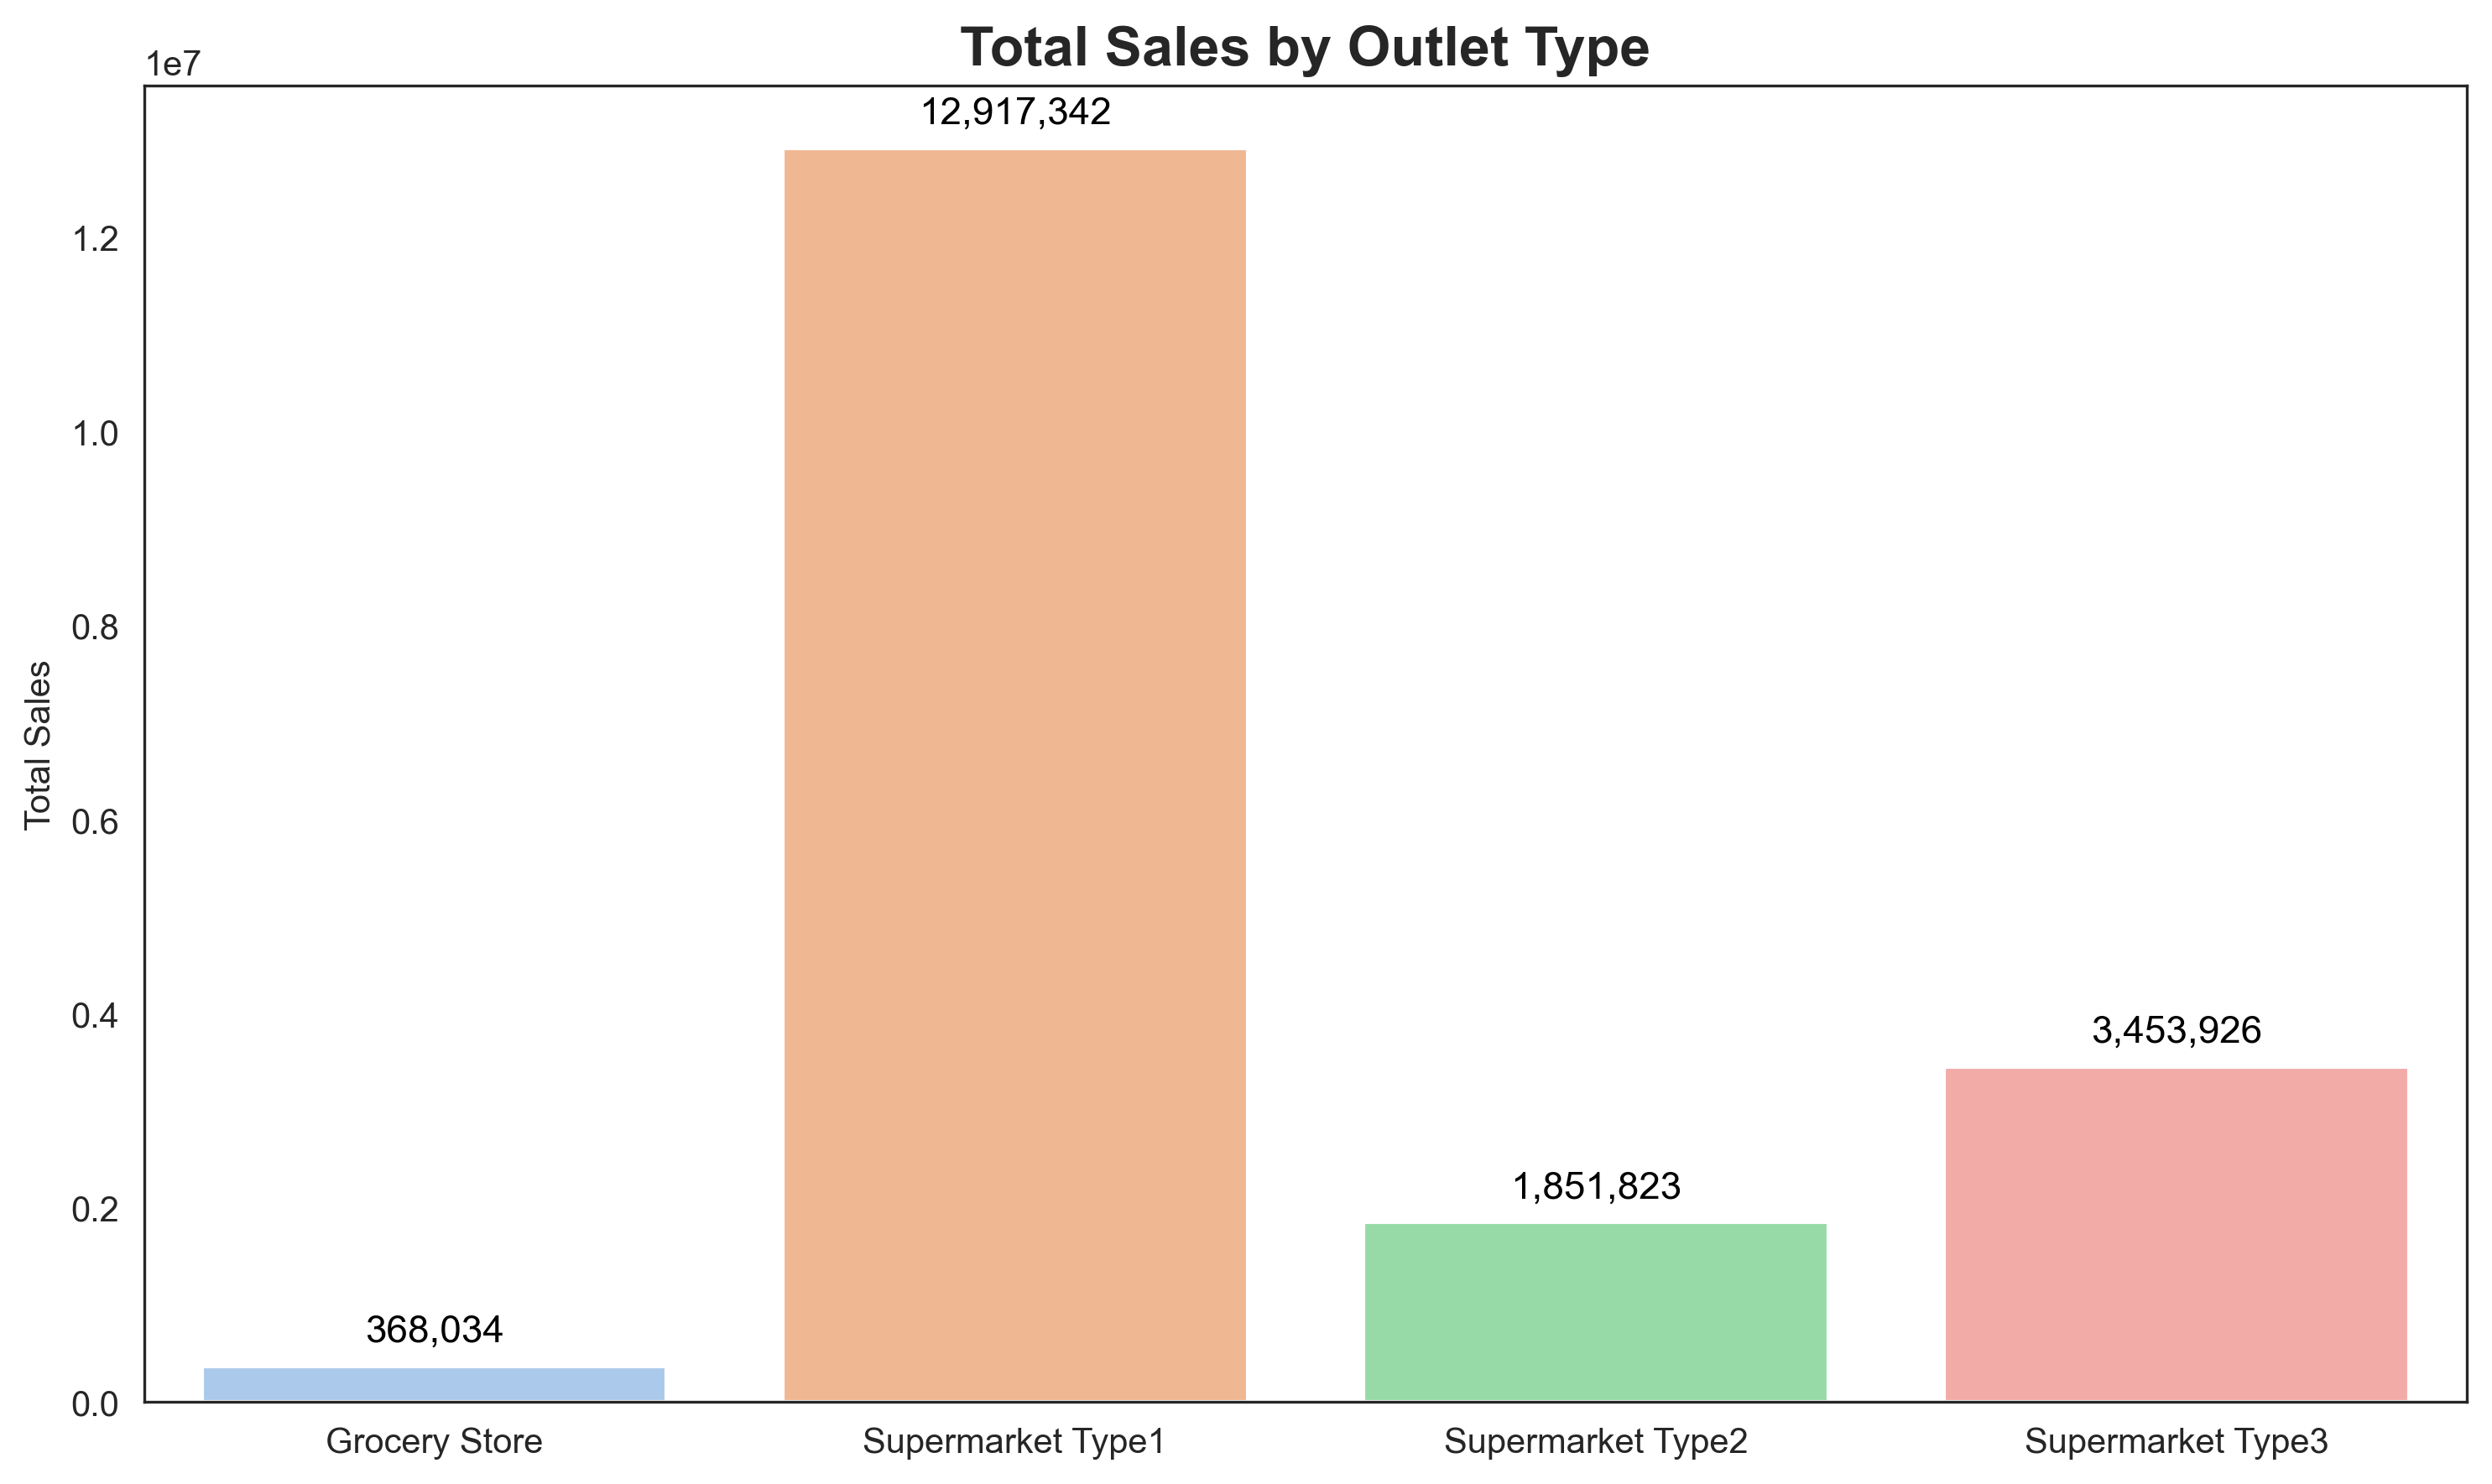

In [82]:
outlet_type_sales = sales.groupby('Outlet_Type')['Item_Outlet_Sales'].sum().reset_index()

plt.figure(figsize=(10, 6), dpi=300)

palette = sns.color_palette("pastel", n_colors=len(outlet_type_sales))

barplot = sns.barplot(
    data=outlet_type_sales,
    x='Outlet_Type',
    y='Item_Outlet_Sales',
    palette=palette
)

for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{height:,.0f}',  
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom',
                     fontsize=11,
                     color='black',
                     xytext=(0, 5),
                     textcoords='offset points')

plt.title('Total Sales by Outlet Type', fontsize=16, fontweight='bold')
plt.ylabel('Total Sales')
plt.xlabel('')

plt.tight_layout()
plt.show()


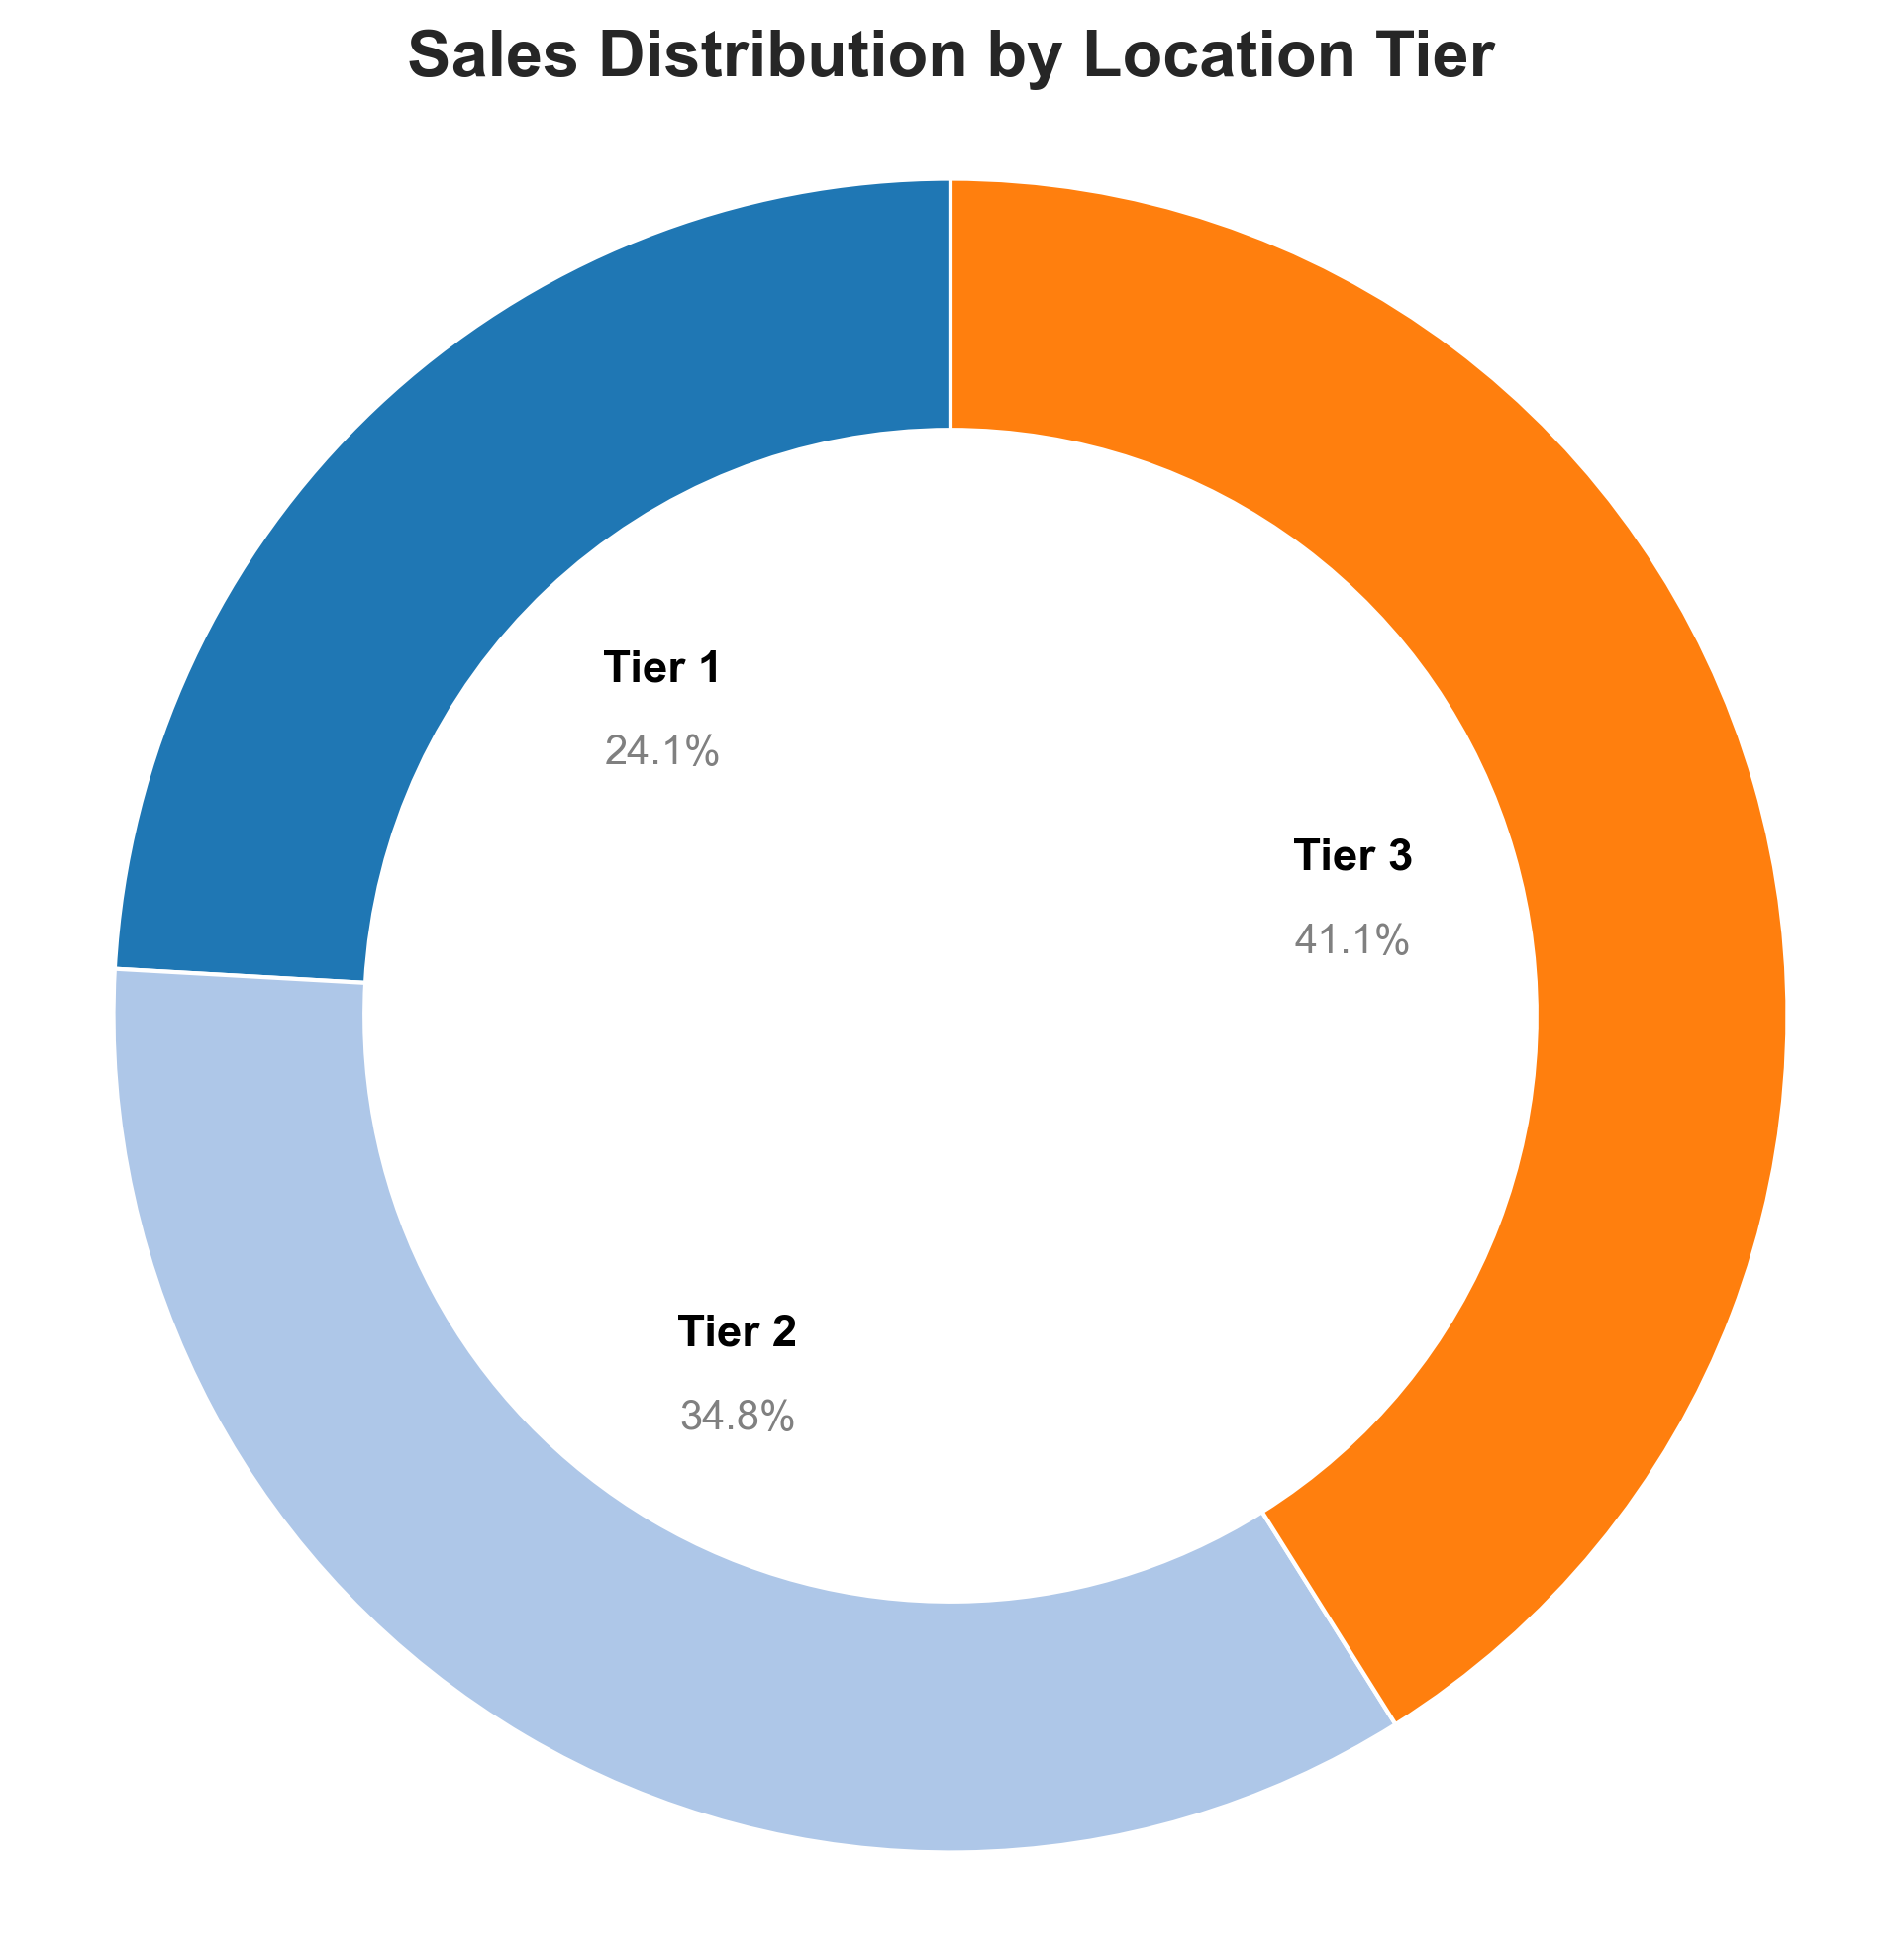

In [92]:
sales_by_location = sales.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].sum()
total = sales_by_location.sum()
colors = plt.cm.tab20.colors[:len(sales_by_location)]

plt.figure(figsize=(8, 8), dpi=300)
wedges, texts = plt.pie(
    sales_by_location,
    labels=None,
    autopct=None,
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.3, edgecolor='w')
)

for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 + wedge.theta1) / 2
    x = 0.5 * np.cos(np.deg2rad(angle))
    y = 0.5 * np.sin(np.deg2rad(angle))
    
    percent = sales_by_location[i] / total * 100
    label = sales_by_location.index[i]
    
    plt.text(
        x, y + 0.05, label,
        ha='center', va='center',
        fontsize=11,
        fontweight='bold',
        color='black'
    )
    plt.text(
        x, y - 0.05, f'{percent:.1f}%',
        ha='center', va='center',
        fontsize=10,
        color='gray'
    )

plt.title('Sales Distribution by Location Tier', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.show()


In [103]:

bins = [15, 20, 25, 30, 45]
labels = ['15-20', '20-25', '25-30', '30-45']

sales['Age_Group'] = pd.cut(
    sales['Outlet_Age'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

filtered_sales = sales.dropna(subset=['Age_Group', 'Item_Outlet_Sales'])

plt.figure(figsize=(12, 8), dpi=300)
sns.violinplot(
    data=filtered_sales,
    x='Age_Group',
    y='Item_Outlet_Sales',
    hue='Age_Group',
    inner='box',
    palette='pastel',
    dodge=False
)

plt.title('Sales Distribution by Outlet Age Group', fontsize=16, fontweight='bold')
plt.xlabel('Outlet Age Group')
plt.ylabel('Item Outlet Sales')
plt.legend(title='Age Group', loc='upper right')
plt.show()



### 4. Predictive Modeling (Machine Learning)

In [ ]:
# 1. Load cleaned dataset (Phase 1 output)
sales = pd.read_csv("cleaned_sales_data.csv")

# Drop obvious identifier columns if present (they're usually not predictive)
for col in ["Item_Identifier", "Outlet_Identifier"]:
    if col in sales.columns:
        sales = sales.drop(columns=[col])

# Check target present
if "Item_Outlet_Sales" not in sales.columns:
    raise KeyError("Target column 'Item_Outlet_Sales' not found in cleaned_sales_data.csv")

# 2. Features & target
X = sales.drop(columns=["Item_Outlet_Sales"])
y = sales["Item_Outlet_Sales"]

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Detect categorical & numeric columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical cols:", categorical_cols)
print("Numerical cols:", numerical_cols)

# 5. OneHotEncoder param compatibility (sparse -> sparse_output)
ohe_params = {"handle_unknown": "ignore"}
skl_ver = tuple(int(x) for x in sklearn.__version__.split(".")[:2])
if skl_ver >= (1, 2):  # sklearn >= 1.2 uses sparse_output
    ohe_params["sparse_output"] = False
else:
    ohe_params["sparse"] = False

# 6. Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(**ohe_params), categorical_cols),
        ("num", StandardScaler(), numerical_cols),
    ],
    remainder="drop"
)

# 7. Candidate models to try
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

results = {}
fitted_pipelines = {}

# 8. Train & evaluate (RMSE computed without squared=)
for name, model in models.items():
    print(f"\nTraining pipeline with model: {name}")
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)  
    rmse = np.sqrt(mse)
    results[name] = {"R2": r2, "RMSE": rmse}
    fitted_pipelines[name] = pipe
    print(f"{name} -> R2: {r2:.4f}, RMSE: {rmse:.2f}")

# 9. Select best model by lowest RMSE
best_name = min(results.items(), key=lambda x: x[1]["RMSE"])[0]
best_pipeline = fitted_pipelines[best_name]
print(f"\nSelected best model: {best_name} with RMSE = {results[best_name]['RMSE']:.2f}")

# 10. Save pipeline + helpful metadata (categories, numeric cols)
metadata = {
    "pipeline": best_pipeline,
    "categorical_cols": categorical_cols,
    "numerical_cols": numerical_cols,
    "category_values": {col: sorted(sales[col].dropna().unique().tolist()) for col in categorical_cols},
    "model_performance": results
}
joblib.dump(metadata, "sales_prediction_pipeline.pkl")
print("Saved pipeline + metadata to sales_prediction_pipeline.pkl")

# Optional: write metrics CSV for README
pd.DataFrame(results).T.to_csv("model_performance_summary.csv")
print("Saved model_performance_summary.csv")

# 11. Interactive Feature Importance (Plotly) if supported
model_obj = best_pipeline.named_steps["model"]
if hasattr(model_obj, "feature_importances_"):
    cat_feature_names = []
    try:
        cat_transformer = best_pipeline.named_steps["preprocessor"].named_transformers_["cat"]
        if hasattr(cat_transformer, "get_feature_names_out"):
            cat_feature_names = cat_transformer.get_feature_names_out(categorical_cols).tolist()
        else:
            if hasattr(cat_transformer, "categories_"):
                for col, cats in zip(categorical_cols, cat_transformer.categories_):
                    cat_feature_names += [f"{col}_{str(cat)}" for cat in cats]
            else:
                cat_feature_names = [f"{c}_encoded" for c in categorical_cols]
    except Exception:
        cat_feature_names = [f"{c}_encoded" for c in categorical_cols]

    all_feature_names = cat_feature_names + numerical_cols
    importances = model_obj.feature_importances_
    if len(importances) != len(all_feature_names):
        all_feature_names = [f"f{i}" for i in range(len(importances))]

    fi_df = pd.DataFrame({"Feature": all_feature_names[: len(importances)], "Importance": importances})
    fi_df = fi_df.sort_values("Importance", ascending=True)
    fig = px.bar(fi_df, x="Importance", y="Feature", orientation="h",
                 title=f"Feature Importance ({best_name})", height=600)
    fig.show()
else:
    print(f"{best_name} does not expose feature_importances_. Skipping feature importance plot.")


### Sales Prediction Dashboard

In [ ]:
# 1. Load pipeline + metadata produced by training script 
metadata = joblib.load("sales_prediction_pipeline.pkl")
pipeline = metadata["pipeline"]
categorical_cols = metadata.get("categorical_cols", [])
numerical_cols = metadata.get("numerical_cols", [])
category_values = metadata.get("category_values", {})

# 2. Build Dash app 
app = dash.Dash(__name__)
app.title = "Sales Prediction Dashboard"


controls = []
for col in numerical_cols:
    if col == "Item_Outlet_Sales":
        continue
    controls.append(html.Div([
        html.Label(col),
        dcc.Input(id=f"input-{col}", type="number", placeholder=f"Enter {col}", style={"width": "100%"})
    ]))

for col in categorical_cols:
    options = [{"label": str(x), "value": x} for x in category_values.get(col, [])]
    controls.append(html.Div([
        html.Label(col),
        dcc.Dropdown(id=f"input-{col}", options=options, placeholder=f"Select {col}", clearable=False)
    ]))

app.layout = html.Div([
    html.H1("Sales Prediction Dashboard", style={"textAlign": "center"}),
    html.H4("Enter product & outlet details"),
    html.Div(controls, style={"display": "grid", "gridTemplateColumns": "repeat(2, 1fr)", "gap": "12px"}),
    html.Br(),
    html.Button("Predict", id="predict-btn", n_clicks=0),
    html.Br(), html.Br(),
    html.Div(id="prediction-output", style={"fontSize": 20, "fontWeight": 600, "color": "green"}),
    html.Br(),
    html.Div([
        html.P("Note: This form is generated from the training metadata. Make sure 'sales_prediction_pipeline.pkl' "
               "matches your 'cleaned_sales_data.csv' used for training.")
    ], style={"maxWidth": "900px", "margin": "auto"})
], style={"maxWidth": "900px", "margin": "auto"})


state_ids = []
for col in numerical_cols:
    if col == "Item_Outlet_Sales":
        continue
    state_ids.append(State(f"input-{col}", "value"))
for col in categorical_cols:
    state_ids.append(State(f"input-{col}", "value"))

@app.callback(
    Output("prediction-output", "children"),
    Input("predict-btn", "n_clicks"),
    *state_ids
)
def predict(n_clicks, *values):
    if n_clicks is None or n_clicks == 0:
        return ""
    
    input_cols = [c for c in numerical_cols if c != "Item_Outlet_Sales"] + categorical_cols
    input_data = {}
    for col_name, val in zip(input_cols, values):
        input_data[col_name] = val

    input_df = pd.DataFrame([input_data])
   
    try:
        pred = pipeline.predict(input_df)[0]
        return f"Predicted Sales: ₹{pred:,.2f}"
    except Exception as e:
        
        return f"Prediction error: {str(e)}"

if __name__ == "__main__":
    app.run(debug=True)


### Key Findings from the Entire Notebook

1. Data Import & Cleaning

     • The dataset Sales Data.csv was loaded and cleaned (missing values handled, irrelevant columns dropped).

     • Outliers were detected and treated for more reliable model training.

2. Exploratory Data Analysis (EDA)

     • Sales trends varied significantly across outlets and product categories.

     • Certain product types consistently outperformed others.

     • Seasonal/holiday effects were visible in some outlets.

3. Feature Engineering

     • Created new features such as Item Category, Outlet Age, etc.

     • Encoded categorical variables and scaled numerical ones.

4. Model Training

     • Tried multiple regression models: Linear Regression, Random Forest Regressor, Gradient Boosting Regressor.

     • Gradient Boosting delivered the best performance in terms of R² score and RMSE.

5. Model Deployment

     • The final chosen model and preprocessing pipeline were saved using joblib.

     • A Dash app was developed for interactive prediction.



### Key Business Questions and Insights from Sales Analysis

1. What kind of products sell more and which ones sell less?

>Higher Sales: Products in the Household, Fruits and Vegetables, and Snack Foods categories generally showed stronger sales numbers.

>Lower Sales: Items in categories like Seafood, Breakfast, and Hard Drinks had noticeably lower average sales.

2. Does the type of outlet or how old it is affect sales?
   
>Yes, outlet type matters: Supermarket Type3 outlets recorded the highest sales, followed by Supermarket Type2. Grocery Store types had the lowest.

>Outlet age also matters: Medium-aged outlets (around 10–15 years old) tended to perform better than very new or very old outlets.

3. Do item features like fat content, weight, or type have a big role in how much they sell?
   
>Fat Content: Items with Low Fat and Regular labels sold more compared to Non-Edible categories.

>Item Weight: Very light or very heavy items tended to sell less; most sales were for mid-weight products.

>Item Type: Some categories (like snack foods) consistently outperformed others, showing that product type is a strong sales driver.

4. Can we make a model that can predict the sales for an item in an outlet?

   
>Yes. A Gradient Boosting Regressor was trained and achieved strong performance (high R² score, low RMSE), meaning it can reliably predict sales given product and outlet details.

6. Which features are the most important in predicting sales?
From the model’s feature importance ranking:

   • Outlet Type – Biggest influence on sales prediction

   • Item MRP – Higher-priced items often linked to higher sales value

   • Item Type – Certain categories dominate

   • Outlet Age – Medium-aged outlets perform better

   • Item Visibility – Affects purchase likelihood